In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
cwd = os.getcwd()
images_path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "images")

In [3]:
### Apply function to values in nested dictionary

def apply_recursive(obj, func):
    if isinstance(obj, dict):  # if dict, apply to each key
        return {k: apply_recursive(v, func) for k, v in obj.items()}
    elif isinstance(obj, list):  # if list, apply to each element
        return [apply_recursive(elem, func) for elem in obj]
    else:
        return func(obj)

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict, level=-1):
    #print(values_dict)
    flat_dict = flatten_dict(values_dict)
    #print(flat_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    # df = df.unstack(level=level)
    # df.columns = df.columns.map("{0[1]}".format)
    return df

def load_to_multi_index(path):
    results_dict = np.load(path, allow_pickle=True) #.item()
    fixed_results_dict = results_dict # apply_recursive(results_dict, lambda df: df.iloc[0].to_dict())
    df = nested_dict_to_df(fixed_results_dict)
    df.index.names = ['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric']
    df.columns = ['Result']
    return df

# debug
# results_dict['UWAVE']['infogain']['resNet']['average']['normalized']['normal_distribution']


def load_from_folder(path):
    filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
    df_list = []
    for filename in filenames:
        filepath = os.path.join(path, filename)
        df = load_to_multi_index(path=filepath)
        df_list.append(df)
    merged_df = pd.concat(df_list)
    return merged_df


In [4]:
cwd = os.getcwd()
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "interprettime_results")
df_first = load_from_folder(path=path)
df_first.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb             Metric             
EOG     binSeg       miniRocket average    normalized    normal_distribution AUCSE_top  0.496721
                                                                             F_score    0.250907
                                                         global_mean         AUCSE_top  0.534784
                                                                             F_score    0.256512
                                                         local_mean          AUCSE_top  0.544627

In [5]:
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "aucdiff_results")
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df_second = merged_df.set_index(['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric'])
df_second.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb   Metric                  
EOG     clasp        miniRocket average    default       insertion AUC_difference  0.080664
                                                         deletion  AUC_difference  0.061430
                                                         insertion AUC_difference  0.037608
                                                         deletion  AUC_difference  0.032819
                                           normalized    insertion AUC_difference  0.079614

In [6]:
df = pd.concat([df_first, df_second]).reset_index()

# QUICKFIX (Temporary)

columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")
all_duplicate = df.duplicated(subset=columns_wo_result)
mean_idxs = df.duplicated(subset=columns_wo_result, keep='last')
std_idxs = df.duplicated(subset=columns_wo_result, keep='first')
df.loc[mean_idxs, "Perturb"] += "_mean"
df.loc[std_idxs, "Perturb"] += "_std"

In [7]:
df

Dataset Segmentation    ML model Background Normalization  \
0        EOG       binSeg  miniRocket    average    normalized   
1        EOG       binSeg  miniRocket    average    normalized   
2        EOG       binSeg  miniRocket    average    normalized   
3        EOG       binSeg  miniRocket    average    normalized   
4        EOG       binSeg  miniRocket    average    normalized   
...      ...          ...         ...        ...           ...   
8635   UWAVE     bottomUp      resNet       zero       default   
8636   UWAVE     bottomUp      resNet       zero    normalized   
8637   UWAVE     bottomUp      resNet       zero    normalized   
8638   UWAVE     bottomUp      resNet       zero    normalized   
8639   UWAVE     bottomUp      resNet       zero    normalized   

                  Perturb          Metric    Result  
0     normal_distribution       AUCSE_top  0.496721  
1     normal_distribution         F_score  0.250907  
2             global_mean       AUCSE_top  0.534784  
3             global_mean         F_score  0.256512  
4              local_mean       AUCSE_top  0.544627  
...                   ...             ...       ...  
8635         deletion_std  AUC_difference  0.130497  
8636       insertion_mean  AUC_difference  0.338062  
8637        deletion_mean  AUC_difference  0.136664  
8638        insertion_std  AUC_difference  0.174196  
8639         deletion_std  AUC_difference  0.135635  

[8640 rows x 8 columns]

## Index and column names

In [8]:
df.index

RangeIndex(start=0, stop=8640, step=1)

In [9]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

## Masking

In [10]:
mask = (df["Metric"] == 'F_score') & (df["Result"] > 1)
df.loc[mask]

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

In [11]:
mask = (df["Metric"] == 'F_score') & (df["Result"] < 0)
df.loc[mask]

Dataset    Segmentation    ML model Background Normalization  \
1153  gunpoint        bottomUp  miniRocket    average    normalized   
1159  gunpoint        bottomUp  miniRocket    average    normalized   
1161  gunpoint        bottomUp  miniRocket    average       default   
1163  gunpoint        bottomUp  miniRocket    average       default   
1167  gunpoint        bottomUp  miniRocket    average       default   
1173  gunpoint        bottomUp  miniRocket       zero    normalized   
1185  gunpoint          binSeg  miniRocket    average    normalized   
1191  gunpoint          binSeg  miniRocket    average    normalized   
1193  gunpoint          binSeg  miniRocket    average       default   
1199  gunpoint          binSeg  miniRocket    average       default   
1217  gunpoint       kernelCPD  miniRocket    average    normalized   
1223  gunpoint       kernelCPD  miniRocket    average    normalized   
1225  gunpoint       kernelCPD  miniRocket    average       default   
1227  gunpoint       kernelCPD  miniRocket    average       default   
1231  gunpoint       kernelCPD  miniRocket    average       default   
1249  gunpoint     windowBased  miniRocket    average    normalized   
1251  gunpoint     windowBased  miniRocket    average    normalized   
1255  gunpoint     windowBased  miniRocket    average    normalized   
1257  gunpoint     windowBased  miniRocket    average       default   
1259  gunpoint     windowBased  miniRocket    average       default   
1263  gunpoint     windowBased  miniRocket    average       default   
1269  gunpoint     windowBased  miniRocket       zero    normalized   
1277  gunpoint     windowBased  miniRocket       zero       default   
1281  gunpoint       nnsegment  miniRocket    average    normalized   
1283  gunpoint       nnsegment  miniRocket    average    normalized   
1287  gunpoint       nnsegment  miniRocket    average    normalized   
1289  gunpoint       nnsegment  miniRocket    average       default   
1291  gunpoint       nnsegment  miniRocket    average       default   
1295  gunpoint       nnsegment  miniRocket    average       default   
1313  gunpoint           equal  miniRocket    average    normalized   
1319  gunpoint           equal  miniRocket    average    normalized   
1321  gunpoint           equal  miniRocket    average       default   
1327  gunpoint           equal  miniRocket    average       default   
1345  gunpoint           clasp  miniRocket    average       default   
1351  gunpoint           clasp  miniRocket    average       default   
1353  gunpoint           clasp  miniRocket    average    normalized   
1359  gunpoint           clasp  miniRocket    average    normalized   
1377  gunpoint  greedygaussian  miniRocket    average       default   
1383  gunpoint  greedygaussian  miniRocket    average       default   
1385  gunpoint  greedygaussian  miniRocket    average    normalized   
1391  gunpoint  greedygaussian  miniRocket    average    normalized   
1409  gunpoint        infogain  miniRocket    average    normalized   
1415  gunpoint        infogain  miniRocket    average    normalized   
1417  gunpoint        infogain  miniRocket    average       default   
1419  gunpoint        infogain  miniRocket    average       default   
1423  gunpoint        infogain  miniRocket    average       default   

                  Perturb   Metric    Result  
1153  normal_distribution  F_score -0.077633  
1159      global_gaussian  F_score -0.077656  
1161  normal_distribution  F_score -0.072358  
1163          global_mean  F_score -0.001675  
1167      global_gaussian  F_score -0.072388  
1173           local_mean  F_score -0.002582  
1185  normal_distribution  F_score -0.077650  
1191      global_gaussian  F_score -0.077772  
1193  normal_distribution  F_score -0.072619  
1199      global_gaussian  F_score -0.072600  
1217  normal_distribution  F_score -0.078111  
1223      global_gaussian  F_score -0.078075  
1225  normal_distribution  F_score -0.073379  
1227       

In [12]:
mask = (df["Metric"] == 'AUC_difference') & (df["Dataset"] == 'KeplerLightCurves') & (df["ML model"] == 'miniRocket')
df.loc[mask]

Dataset Segmentation    ML model Background Normalization  \
6048  KeplerLightCurves        clasp  miniRocket    average       default   
6049  KeplerLightCurves        clasp  miniRocket    average       default   
6050  KeplerLightCurves        clasp  miniRocket    average       default   
6051  KeplerLightCurves        clasp  miniRocket    average       default   
6052  KeplerLightCurves        clasp  miniRocket    average    normalized   
...                 ...          ...         ...        ...           ...   
6187  KeplerLightCurves    kernelCPD  miniRocket       zero       default   
6188  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6189  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6190  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   
6191  KeplerLightCurves    kernelCPD  miniRocket       zero    normalized   

             Perturb          Metric    Result  
6048  insertion_mean  AUC_difference  0.218415  
6049   deletion_mean  AUC_difference  0.210476  
6050   insertion_std  AUC_difference  0.092925  
6051    deletion_std  AUC_difference  0.086397  
6052  insertion_mean  AUC_difference  0.222677  
...              ...             ...       ...  
6187    deletion_std  AUC_difference  0.087248  
6188  insertion_mean  AUC_difference  0.241533  
6189   deletion_mean  AUC_difference  0.207713  
6190   insertion_std  AUC_difference  0.113392  
6191    deletion_std  AUC_difference  0.079571  

[144 rows x 8 columns]

In [13]:
mask = (df["Metric"] == 'AUCSE_top') & (df["Result"] < 0)
df.loc[mask]

Dataset    Segmentation    ML model Background Normalization  \
1152  gunpoint        bottomUp  miniRocket    average    normalized   
1154  gunpoint        bottomUp  miniRocket    average    normalized   
1158  gunpoint        bottomUp  miniRocket    average    normalized   
1160  gunpoint        bottomUp  miniRocket    average       default   
1162  gunpoint        bottomUp  miniRocket    average       default   
1166  gunpoint        bottomUp  miniRocket    average       default   
1184  gunpoint          binSeg  miniRocket    average    normalized   
1186  gunpoint          binSeg  miniRocket    average    normalized   
1190  gunpoint          binSeg  miniRocket    average    normalized   
1192  gunpoint          binSeg  miniRocket    average       default   
1194  gunpoint          binSeg  miniRocket    average       default   
1198  gunpoint          binSeg  miniRocket    average       default   
1216  gunpoint       kernelCPD  miniRocket    average    normalized   
1218  gunpoint       kernelCPD  miniRocket    average    normalized   
1222  gunpoint       kernelCPD  miniRocket    average    normalized   
1224  gunpoint       kernelCPD  miniRocket    average       default   
1226  gunpoint       kernelCPD  miniRocket    average       default   
1230  gunpoint       kernelCPD  miniRocket    average       default   
1248  gunpoint     windowBased  miniRocket    average    normalized   
1250  gunpoint     windowBased  miniRocket    average    normalized   
1254  gunpoint     windowBased  miniRocket    average    normalized   
1256  gunpoint     windowBased  miniRocket    average       default   
1258  gunpoint     windowBased  miniRocket    average       default   
1262  gunpoint     windowBased  miniRocket    average       default   
1268  gunpoint     windowBased  miniRocket       zero    normalized   
1276  gunpoint     windowBased  miniRocket       zero       default   
1280  gunpoint       nnsegment  miniRocket    average    normalized   
1282  gunpoint       nnsegment  miniRocket    average    normalized   
1286  gunpoint       nnsegment  miniRocket    average    normalized   
1288  gunpoint       nnsegment  miniRocket    average       default   
1290  gunpoint       nnsegment  miniRocket    average       default   
1294  gunpoint       nnsegment  miniRocket    average       default   
1300  gunpoint       nnsegment  miniRocket       zero    normalized   
1308  gunpoint       nnsegment  miniRocket       zero       default   
1312  gunpoint           equal  miniRocket    average    normalized   
1314  gunpoint           equal  miniRocket    average    normalized   
1318  gunpoint           equal  miniRocket    average    normalized   
1320  gunpoint           equal  miniRocket    average       default   
1322  gunpoint           equal  miniRocket    average       default   
1326  gunpoint           equal  miniRocket    average       default   
1344  gunpoint           clasp  miniRocket    average       default   
1350  gunpoint           clasp  miniRocket    average       default   
1352  gunpoint           clasp  miniRocket    average    normalized   
1358  gunpoint           clasp  miniRocket    average    normalized   
1376  gunpoint  greedygaussian  miniRocket    average       default   
1378  gunpoint  greedygaussian  miniRocket    average       default   
1382  gunpoint  greedygaussian  miniRocket    average       default   
1384  gunpoint  greedygaussian  miniRocket    average    normalized   
1386  gunpoint  greedygaussian  miniRocket    average    normalized   
1390  gunpoint  greedygaussian  miniRocket    average    normalized   
1408  gunpoint        infogain  miniRocket    average    normalized   
1410  gunpoint        infogain  miniRocket    average    normalized   
1414  gunpoint        infogain  miniRocket    average    normalized   
1416  gunpoint        infogain  miniRocket    average       default   
1418  gunpoint        infogain  miniRocket    average       default   
1422  gunpoint        infogain 

In [14]:
mask = (df["Metric"] == 'AUC_difference') & (df["Result"].isna())
df.loc[mask].head()

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

In [15]:
mask = (df["Metric"] == 'AUC_difference') & (df["Result"] < 0)
df.loc[mask].head()

Empty DataFrame
Columns: [Dataset, Segmentation, ML model, Background, Normalization, Perturb, Metric, Result]
Index: []

# Data Analysis

## Correlation matrix

In [16]:
mask = (df["Metric"]=='AUCSE_top')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [17]:
mask = (df["Metric"]=='F_score')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [18]:
# df2 = df.unstack(["Metric"])
# df2.columns = df2.columns.droplevel(0)
# corr = df2.corr()
# coef_det = corr ** 2
# coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [19]:
df["Perturb"].unique()

array(['normal_distribution', 'global_mean', 'local_mean',
       'global_gaussian', 'insertion_mean', 'deletion_mean',
       'insertion_std', 'deletion_std'], dtype=object)

In [20]:
values_to_delete = ['insertion_std', 'deletion_std']
values_to_aggregate = ['normal_distribution', 'global_mean', 'local_mean', 'global_gaussian']
filtered_df = df[~df['Perturb'].isin(values_to_delete)]
to_aggregate = filtered_df[filtered_df['Perturb'].isin(values_to_aggregate)]
to_keep = filtered_df[~filtered_df['Perturb'].isin(values_to_aggregate)]
group_cols = [col for col in filtered_df.columns if col not in ['Perturb', 'Result']]
aggregated = to_aggregate.groupby(group_cols, as_index=False)['Result'].mean()
aggregated['Perturb'] = 'mean'
pivoted = to_keep.pivot_table(index=to_keep.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
pivoted['Result'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
pivoted['Perturb'] = 'mean'
pivoted = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)
final_df = pd.concat([pivoted, aggregated])
pivoted = final_df.pivot(index=final_df.columns.difference(['Metric', 'Result']).tolist(), columns='Metric', values='Result')
corr_matrix = pivoted.corr()
print("\nCorr Matrix:", corr_matrix)



Corr Matrix: Metric          AUCSE_top  AUC_difference   F_score
Metric                                             
AUCSE_top        1.000000        0.621939  0.911627
AUC_difference   0.621939        1.000000  0.517965
F_score          0.911627        0.517965  1.000000


In [21]:
pivoted

Metric                                                             AUCSE_top  \
Background Dataset  ML model Normalization Perturb Segmentation                
average    EOG      QUANT    default       mean    binSeg           0.740229   
                                                   bottomUp         0.732698   
                                                   clasp            0.687468   
                                                   equal            0.760297   
                                                   greedygaussian   0.762208   
...                                                                      ...   
zero       gunpoint resNet   normalized    mean    greedygaussian   0.407765   
                                                   infogain         0.410085   
                                                   kernelCPD        0.412970   
                                                   nnsegment        0.409098   
                                                   windowBased      0.373351   

Metric                                                             AUC_difference  \
Background Dataset  ML model Normalization Perturb Segmentation                     
average    EOG      QUANT    default       mean    binSeg                0.269965   
                                                   bottomUp              0.260495   
                                                   clasp                 0.149023   
                                                   equal                 0.295504   
                                                   greedygaussian        0.304445   
...                                                                           ...   
zero       gunpoint resNet   normalized    mean    greedygaussian       -0.001133   
                                                   infogain             -0.042666   
                                                   kernelCPD            -0.044329   
                                                   nnsegment             0.014498   
                                                   windowBased          -0.033213   

Metric                                                              F_score  
Background Dataset  ML model Normalization Perturb Segmentation              
average    EOG      QUANT    default       mean    binSeg          0.311659  
                                                   bottomUp        0.307139  
                                                   clasp           0.294981  
                                                   equal           0.315811  
                                                   greedygaussian  0.314152  
...                                                                     ...  
zero       gunpoint resNet   normalized    mean    greedygaussian  0.159752  
                                                   infogain        0.152598  
                                                   kernelCPD       0.163099  
                                                   nnsegment       0.158725  
                                                   windowBased     0.077381  

[720 rows x 3 columns]

In [24]:
to_remove = (df["Segmentation"]=='windowBased')
df = df[~to_remove]

values_to_delete = ['insertion_std', 'deletion_std']
values_to_aggregate = ['deletion_mean', 'insertion_mean']
filtered_df = df[~df['Perturb'].isin(values_to_delete)]
to_aggregate = filtered_df[filtered_df['Perturb'].isin(values_to_aggregate)]
to_keep = filtered_df[~filtered_df['Perturb'].isin(values_to_aggregate)]

pivoted = to_aggregate.pivot_table(index=to_aggregate.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
pivoted['mean'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
pivoted['Perturb'] = 'mean'
pivoted = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)

cat_cols = to_aggregate.columns.difference(['Perturb', 'Result'])

melted = pivoted.melt(
        id_vars=cat_cols,
        value_vars=['mean'],
        var_name='Perturb',
        value_name='Result'
    ).dropna(subset=['Result'])

final_df = pd.concat([to_keep, melted])#.reset_index()

df = final_df


### AUCSE_top
#### local_mean vs global_mean

In [27]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

In [28]:
columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")

In [29]:
columns_wo_result

['Dataset',
 'Segmentation',
 'ML model',
 'Background',
 'Normalization',
 'Perturb',
 'Metric']

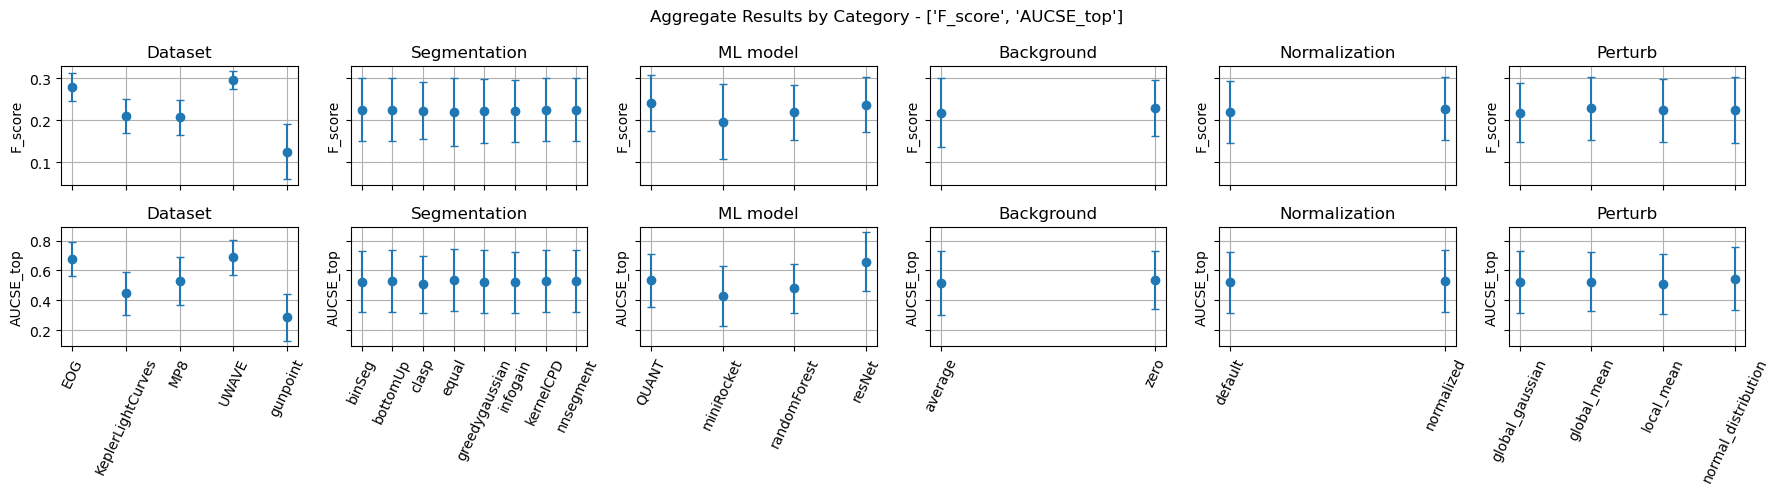

In [30]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
metric_names = ['F_score', 'AUCSE_top']

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (18,5), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3_mean = df3[("Result", "mean")]
        df3_std = df3[("Result", "std")]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(metric_name)

for axis, metric_name in zip(ax[:, 0], metric_names):
    axis.set_ylabel(metric_name)

fig.suptitle("Aggregate Results by Category - " + str(metric_names))
fig.tight_layout()

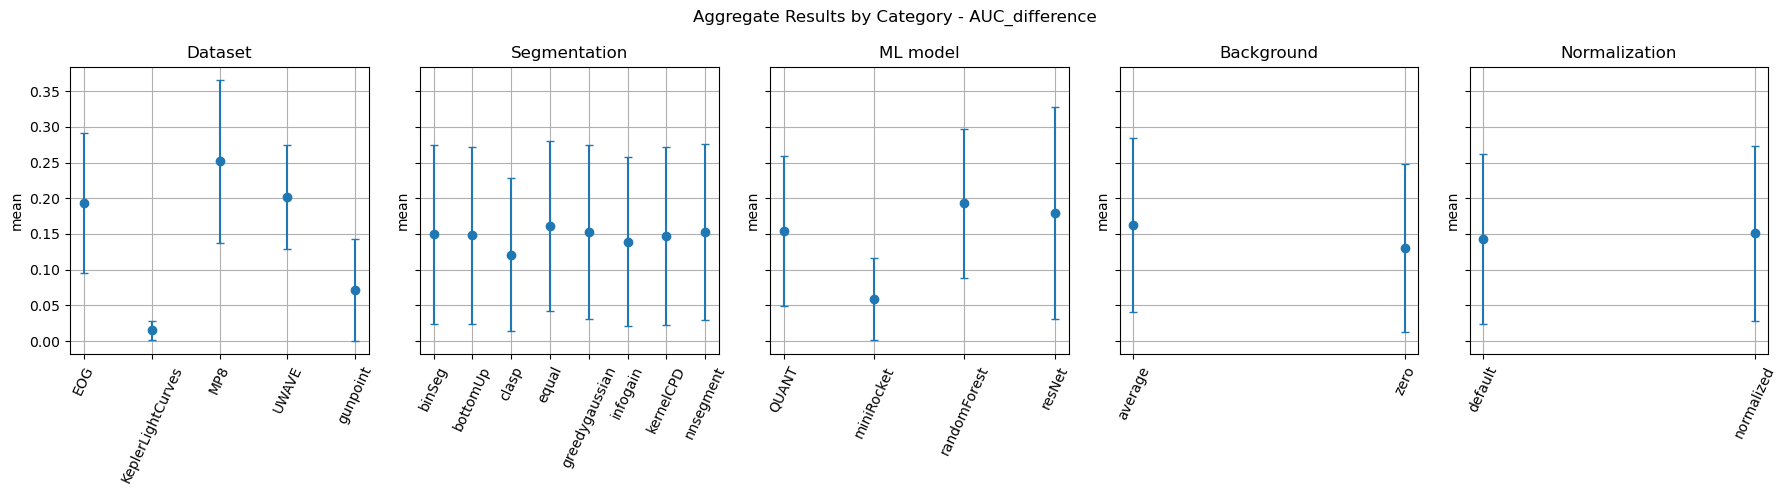

In [31]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Perturb")
metric_name = "AUC_difference"


perturb_names = ["mean"]

fig, ax = plt.subplots(len(perturb_names), len(active_columns), figsize = (18, 5), sharex="col", sharey=True, squeeze=False)

for j, perturb_name in enumerate(perturb_names):

    mask = (df["Metric"]==metric_name) & (df["Perturb"]==perturb_name)
    df2 = df.loc[mask]

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3.columns = df3.columns.get_level_values(1)
        df3_mean = df3["mean"]
        df3_std = df3["std"]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(perturb_name)


for axis, perturb_name in zip(ax[:, 0], perturb_names):
    axis.set_ylabel(perturb_name)

fig.suptitle("Aggregate Results by Category - " + metric_name)
fig.tight_layout()

In [32]:
from itertools import combinations

In [33]:
# for col in df2[active_columns]:
#     print(col)
#     print(len(df2[col].unique()))

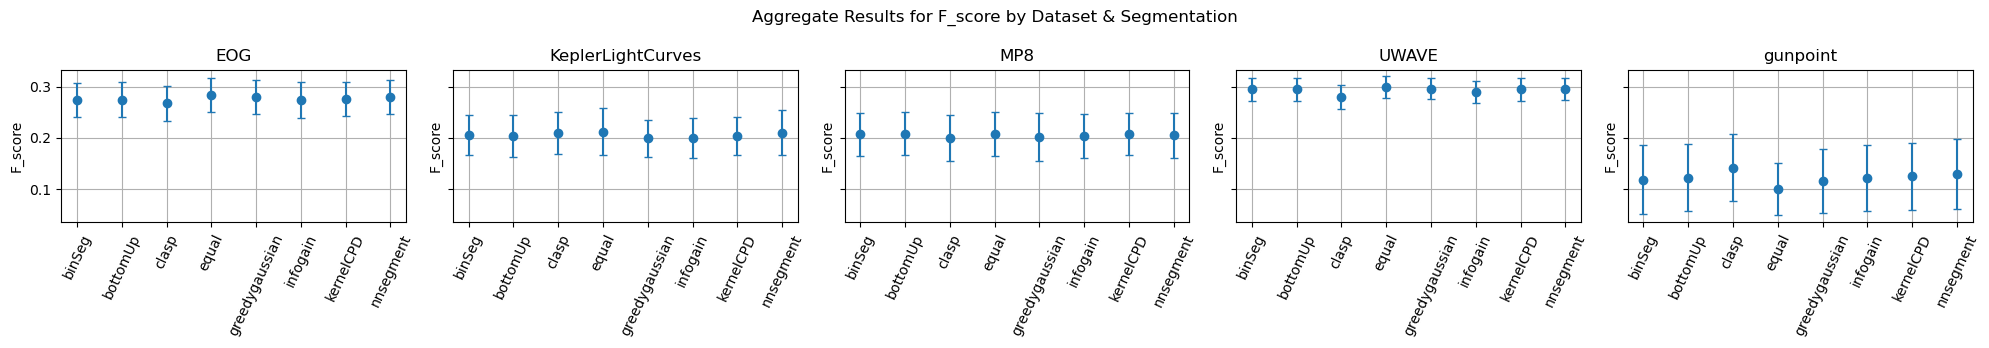

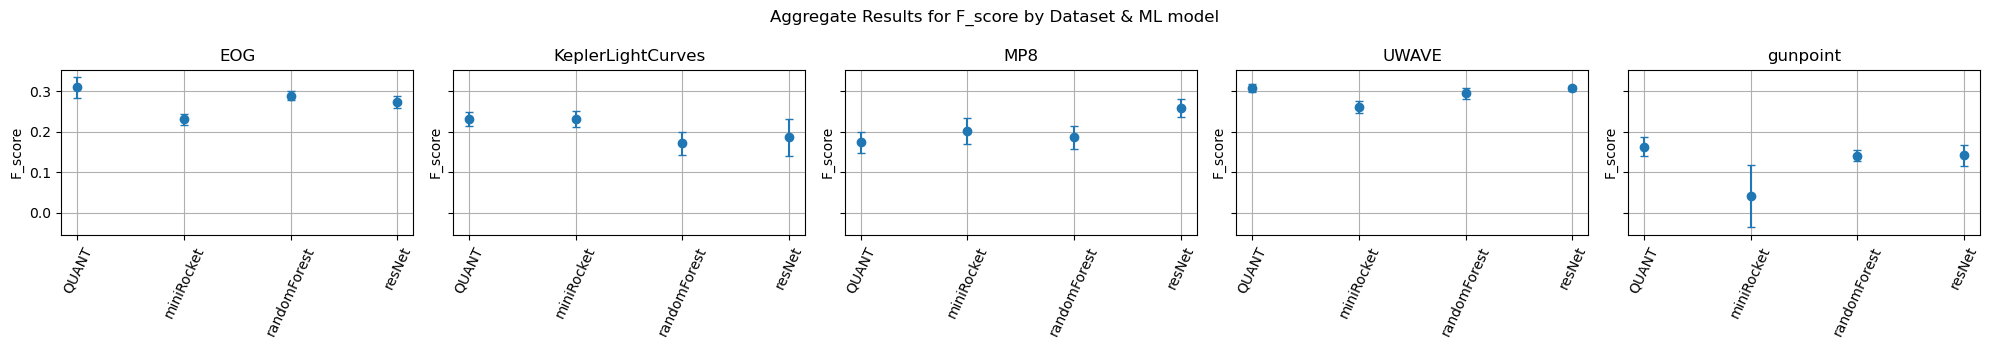

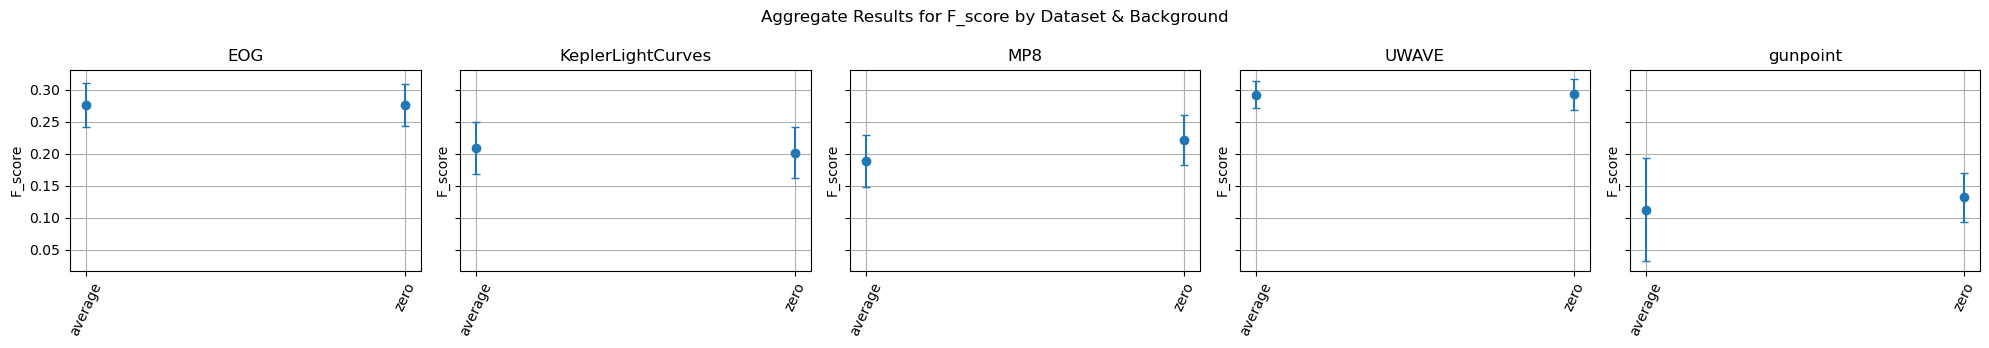

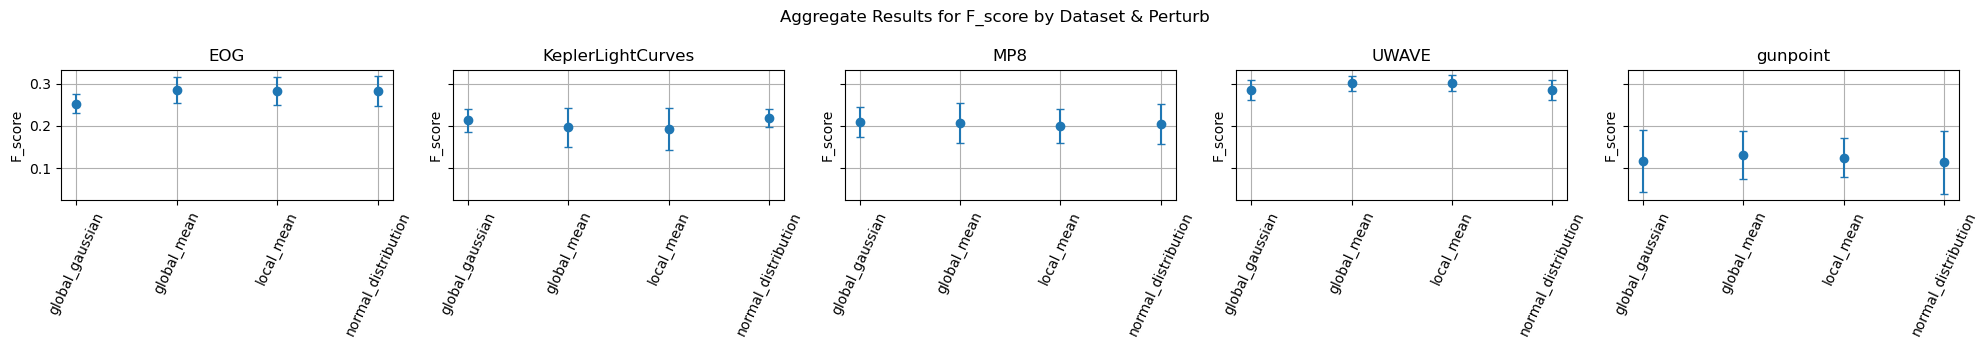

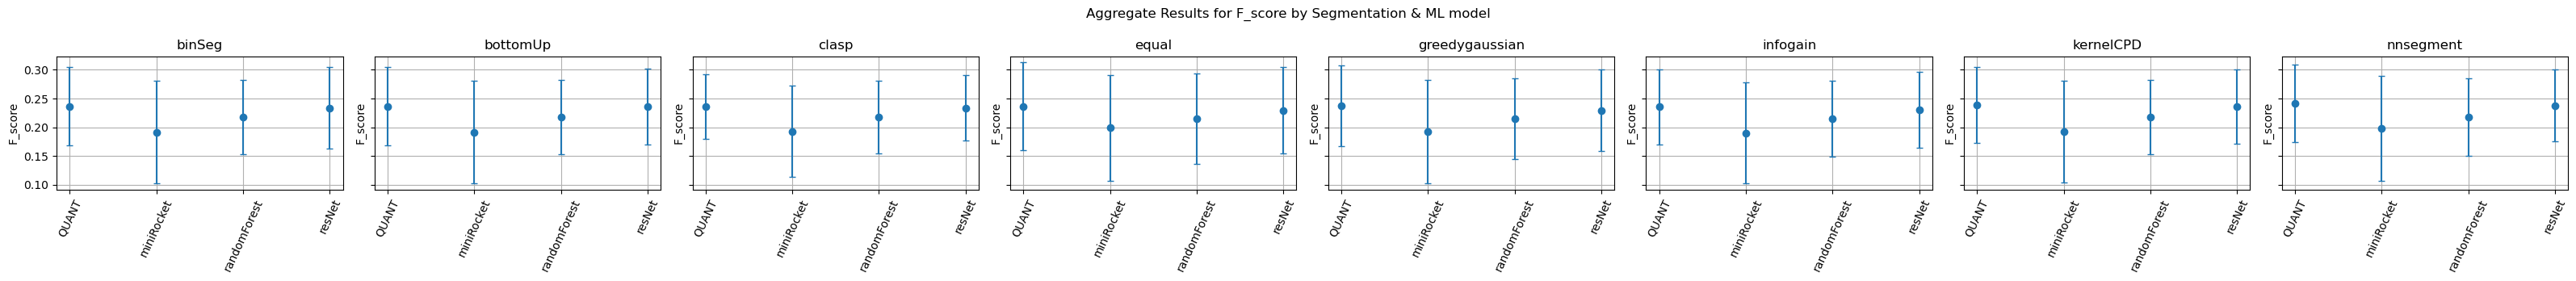

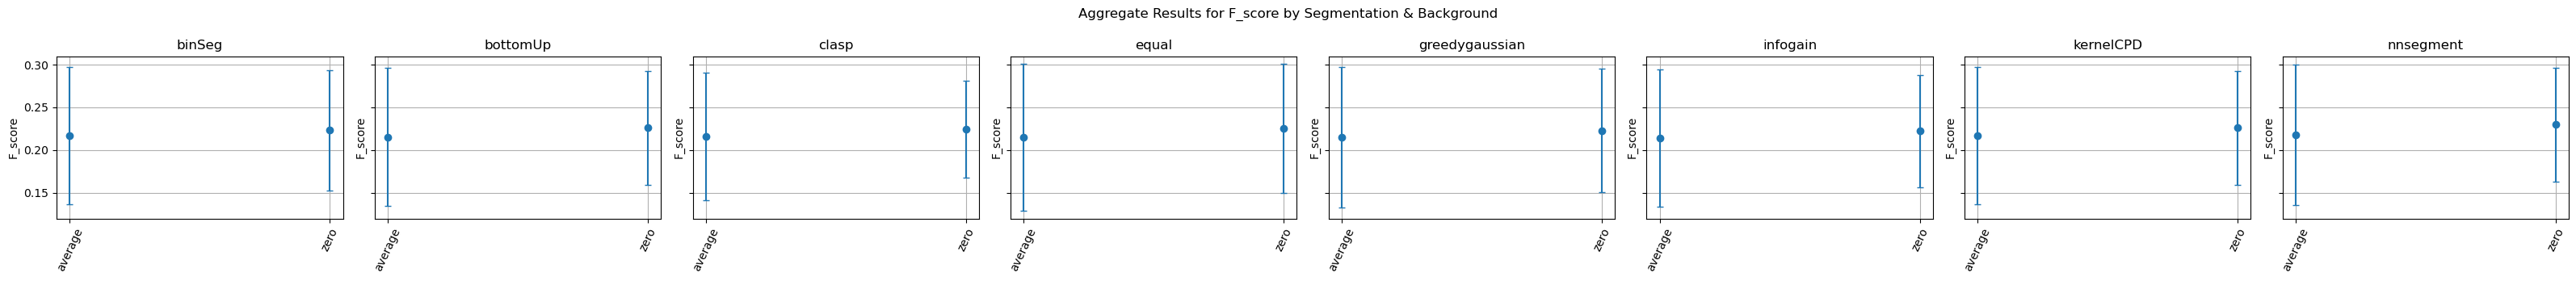

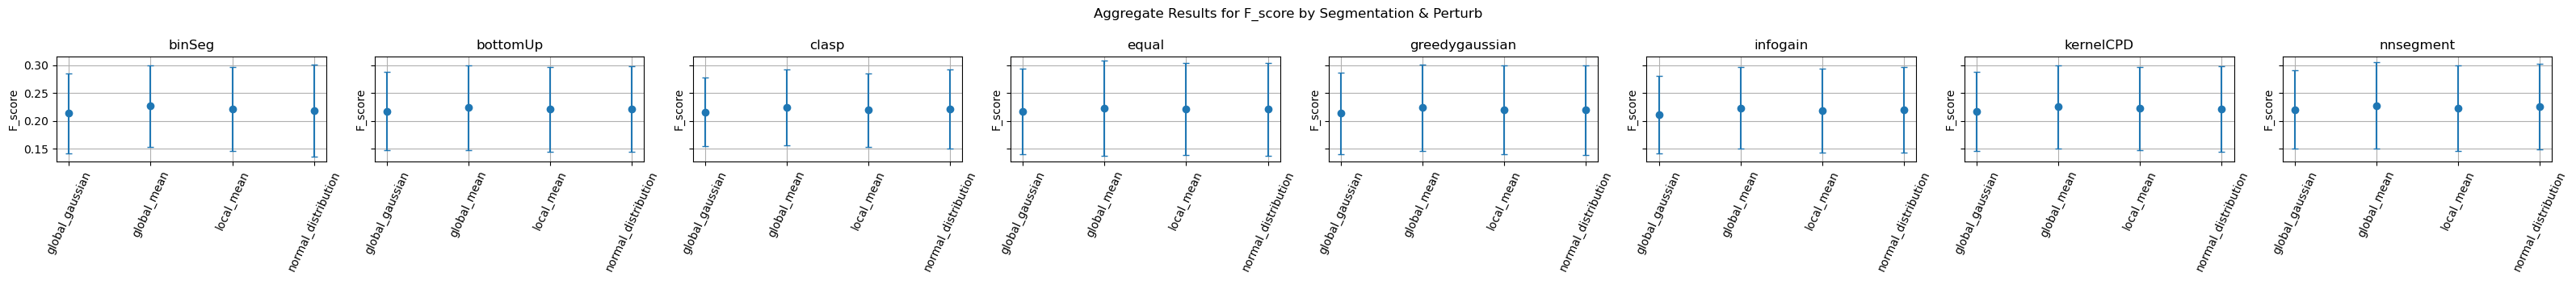

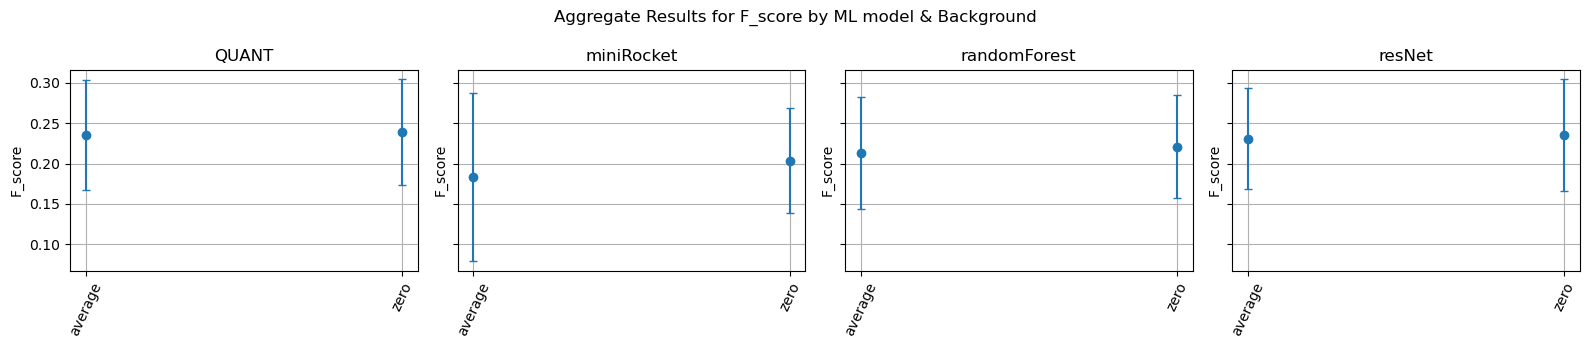

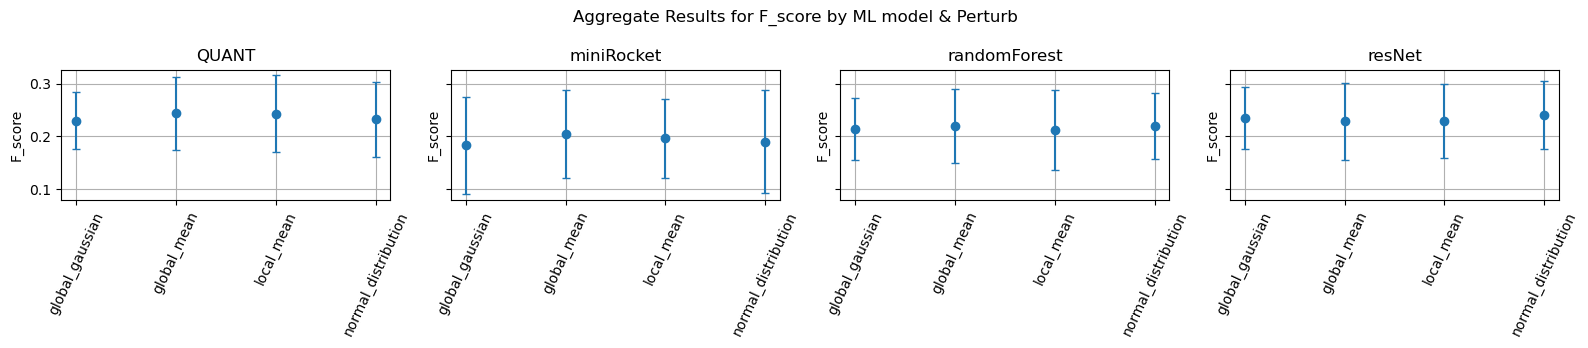

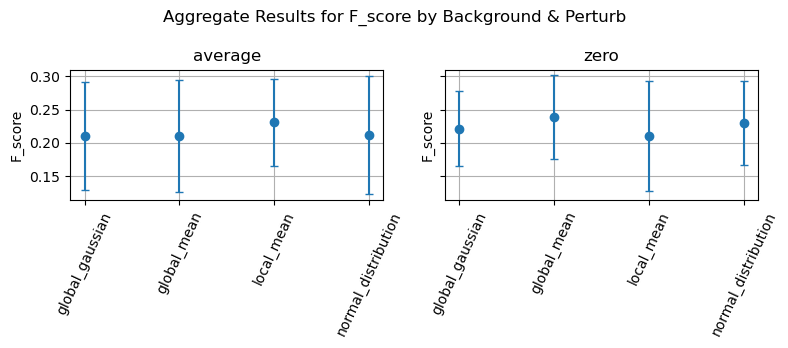

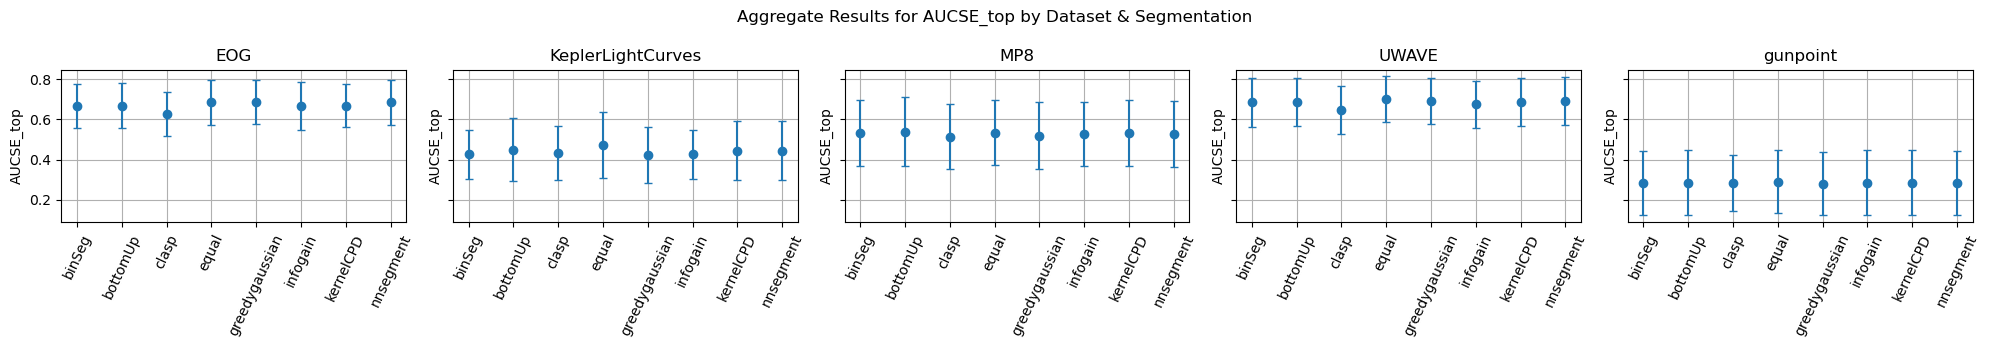

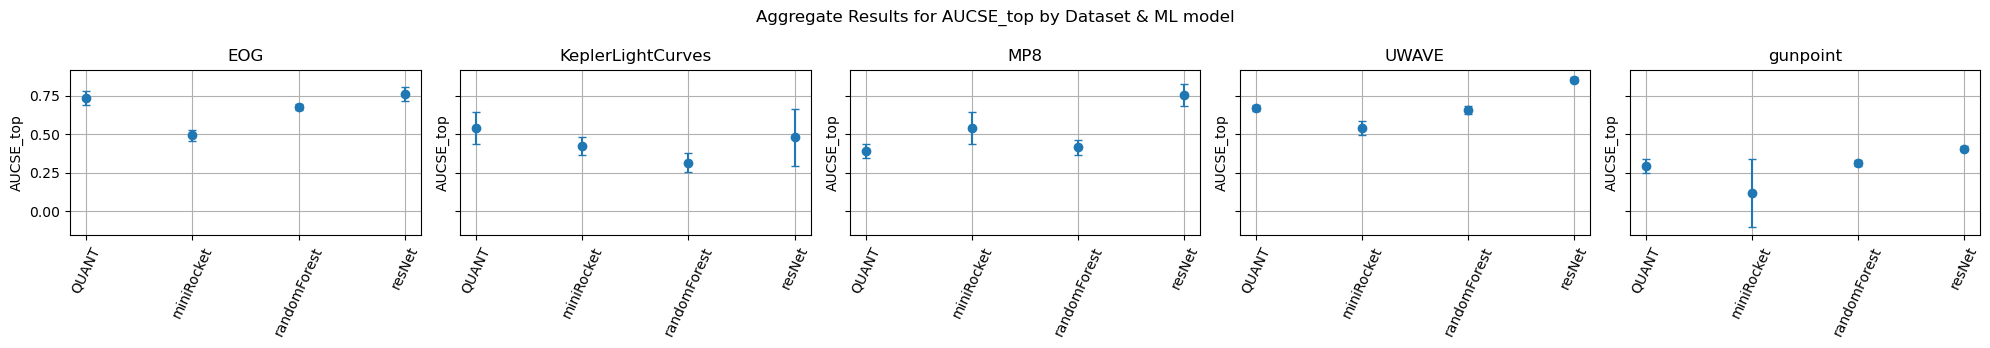

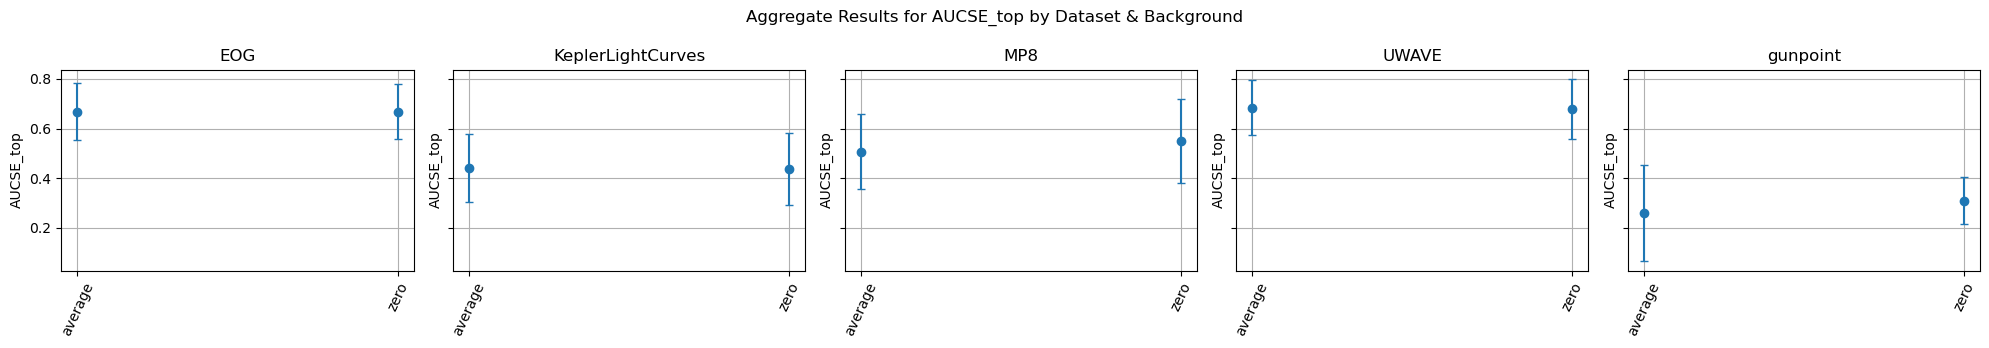

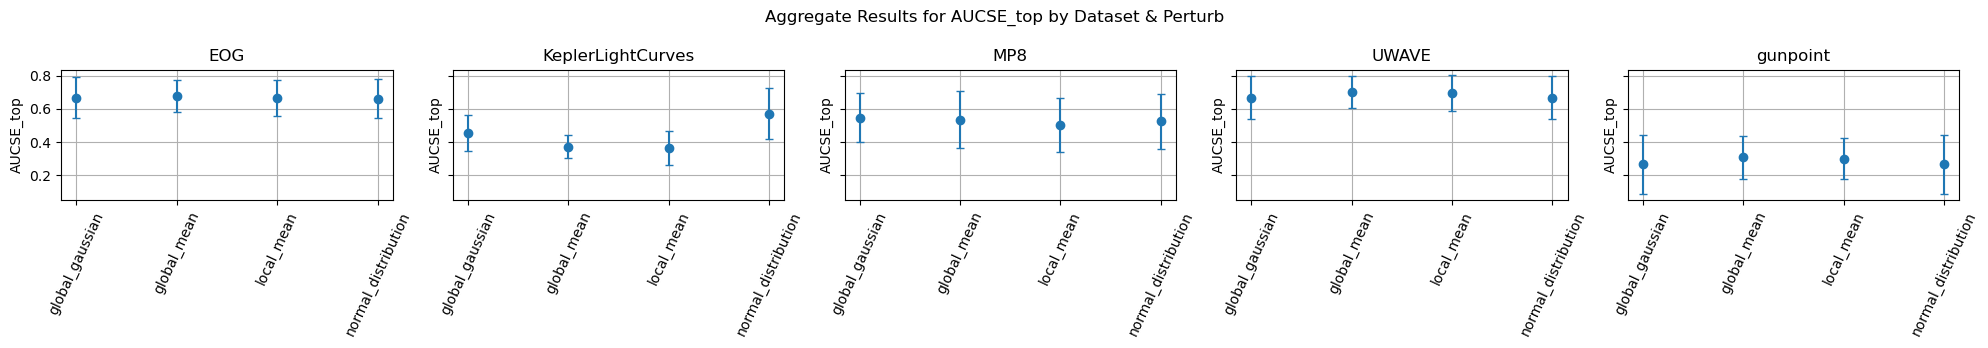

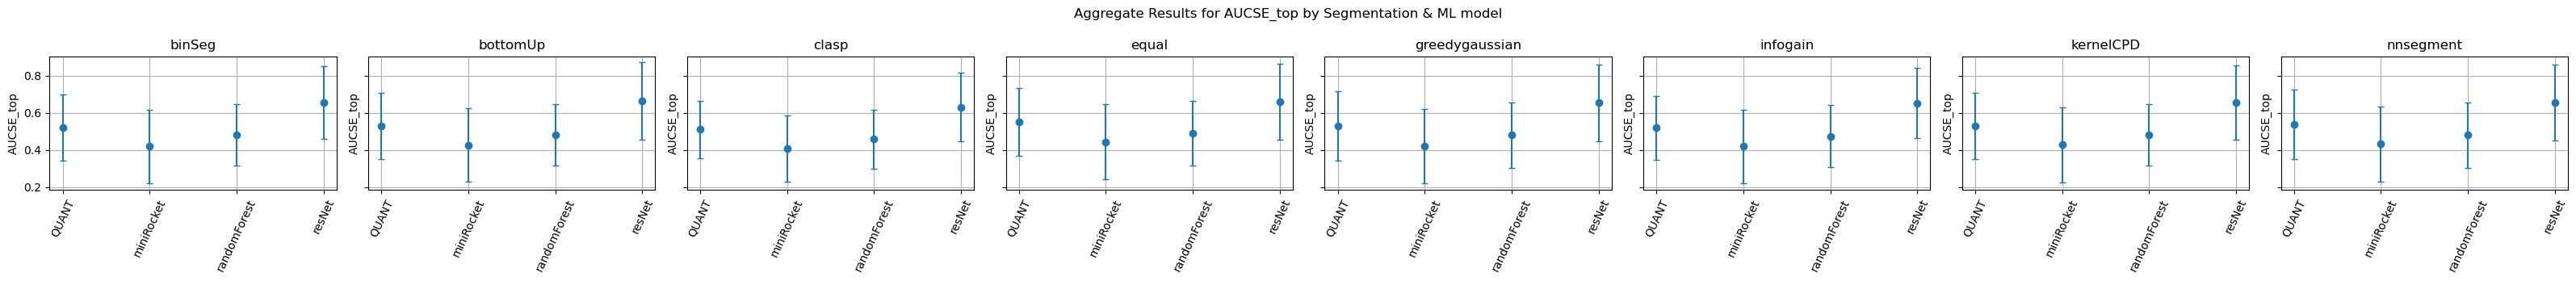

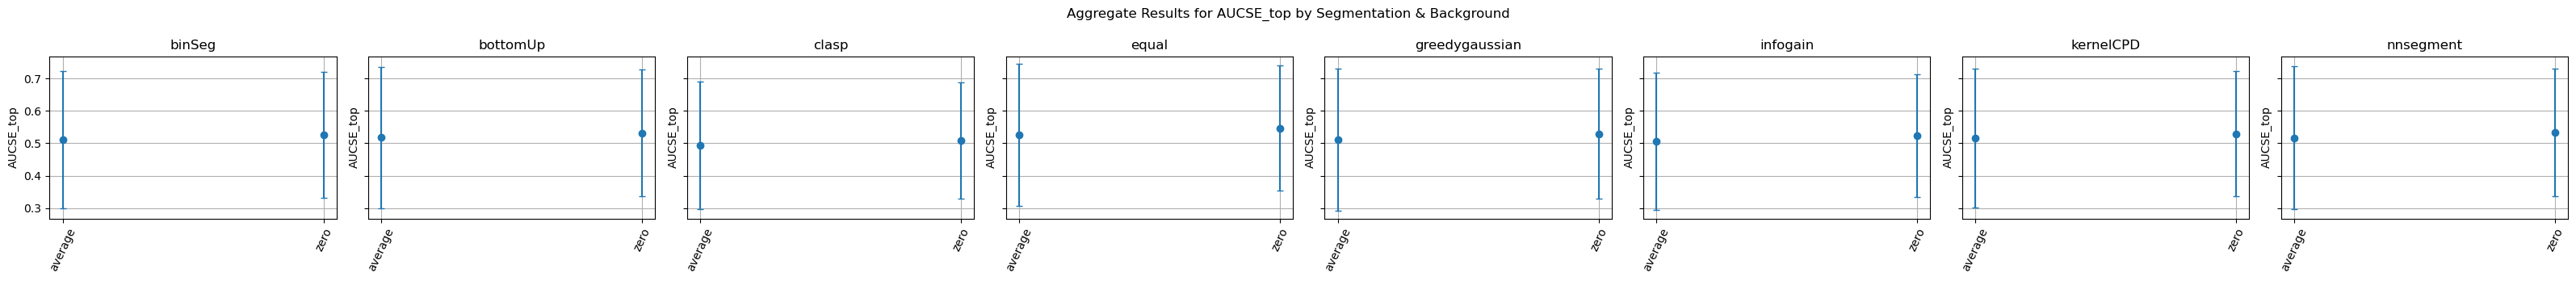

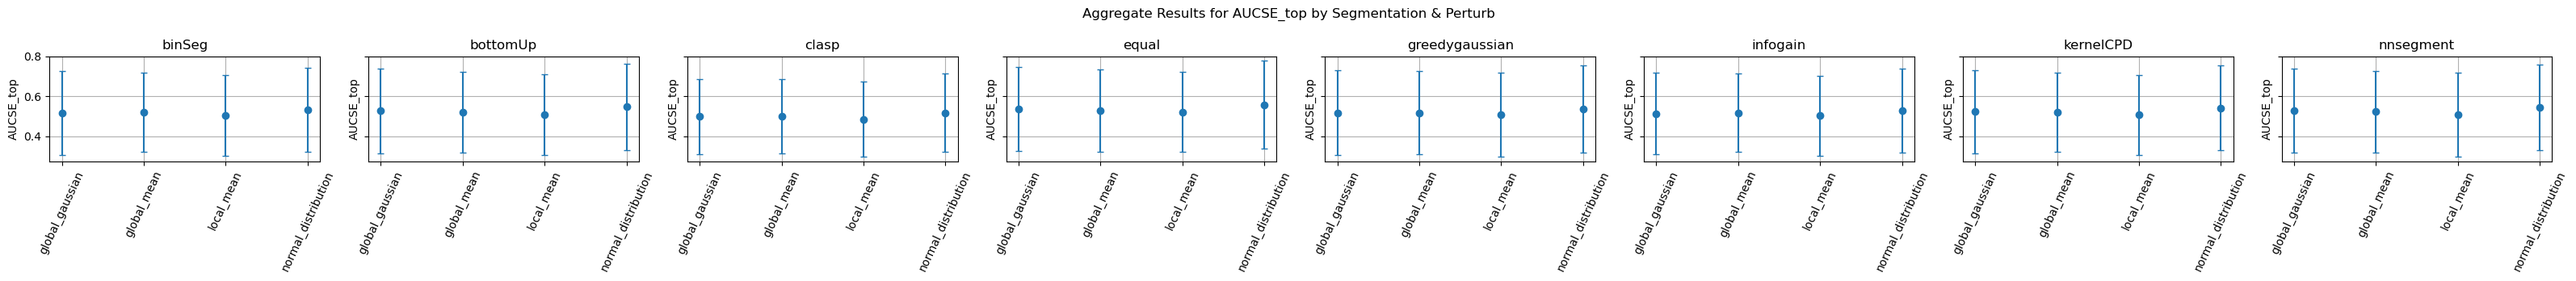

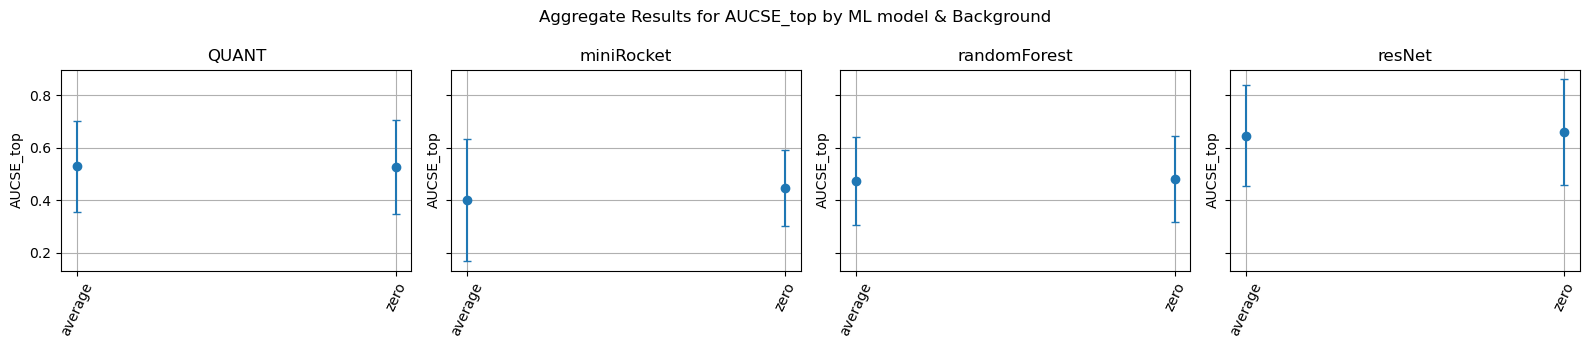

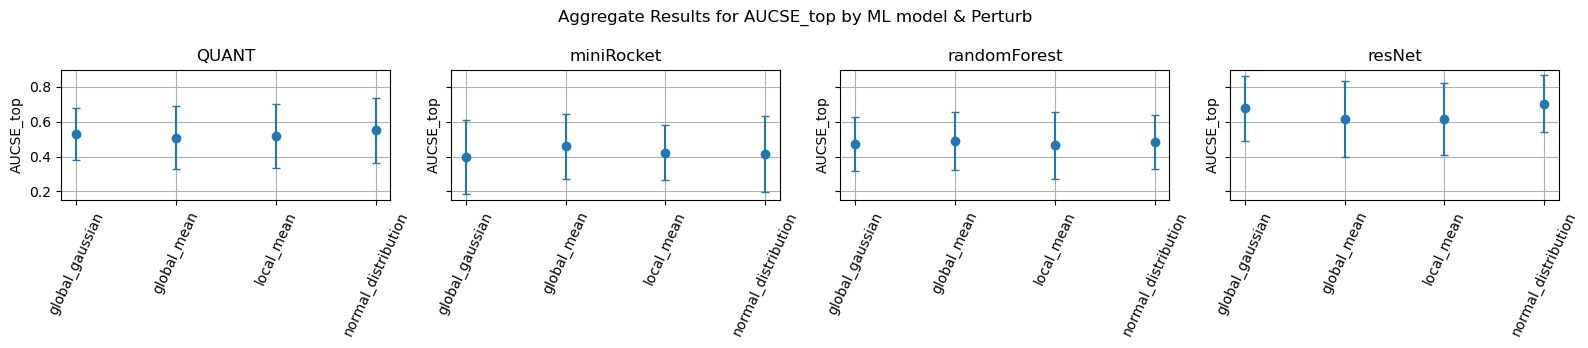

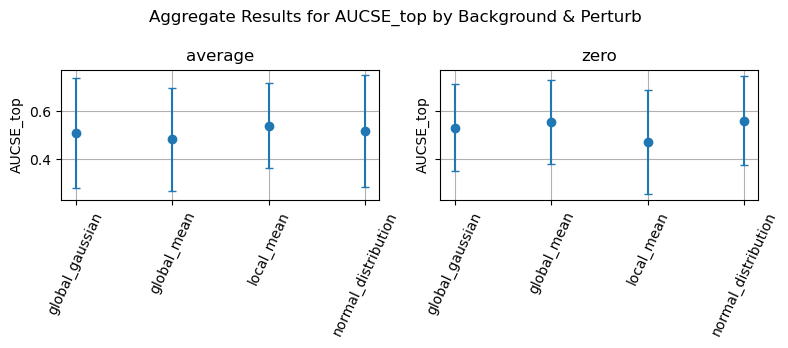

In [34]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_combinations = list(combinations(active_columns, 2))  # [["Dataset", "ML model"]] #
metric_names = ["F_score", 'AUCSE_top']

for metric_name in metric_names:

    mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    # col_unique_lengths = []
    # for col in df2[active_columns]:
    #     col_unique_lengths.append(len(df2[col].unique()))
    # n_rows = len(active_combinations)
    # max_cols = np.max(col_unique_lengths)

    for column_names in active_combinations:
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100


In [35]:
# perturbations matter on Kepler
# gunpoint minirocket
# kepler resnet

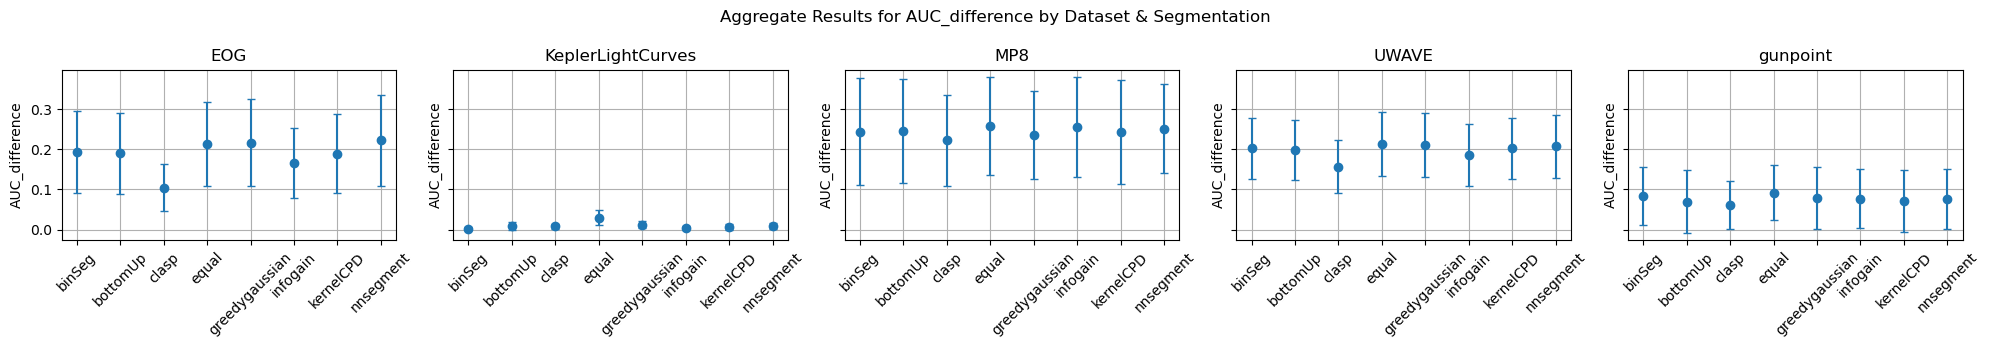

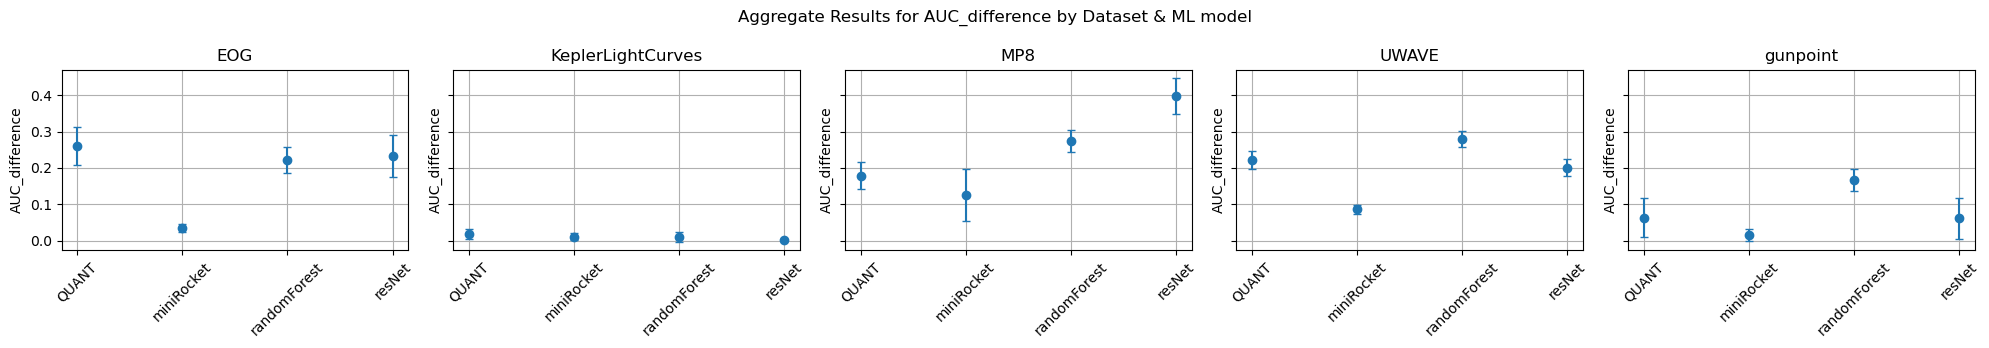

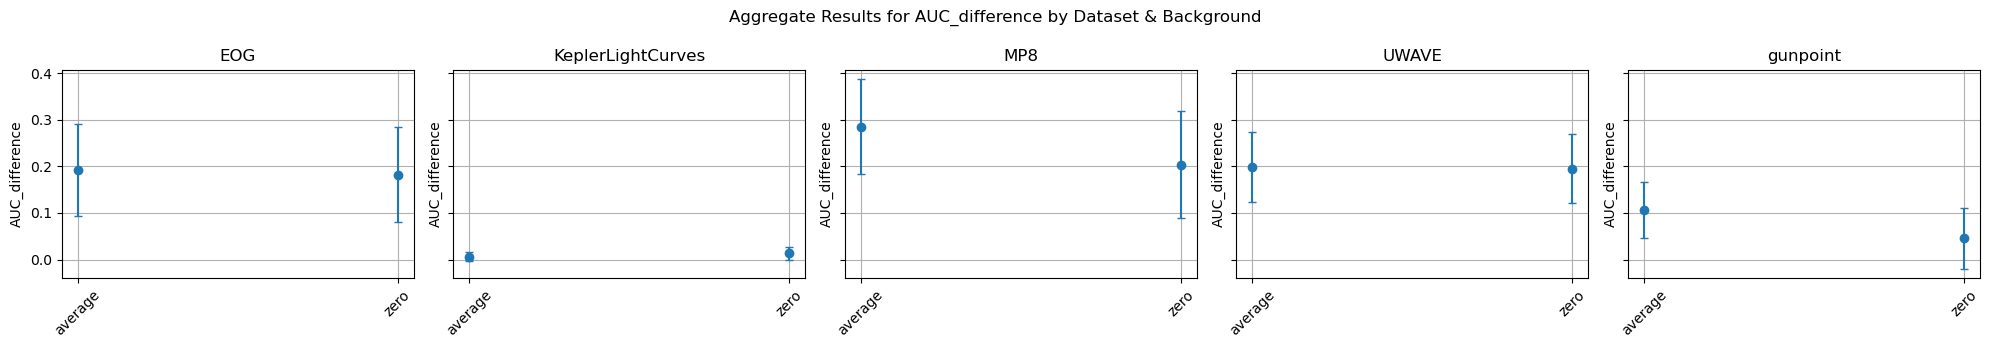

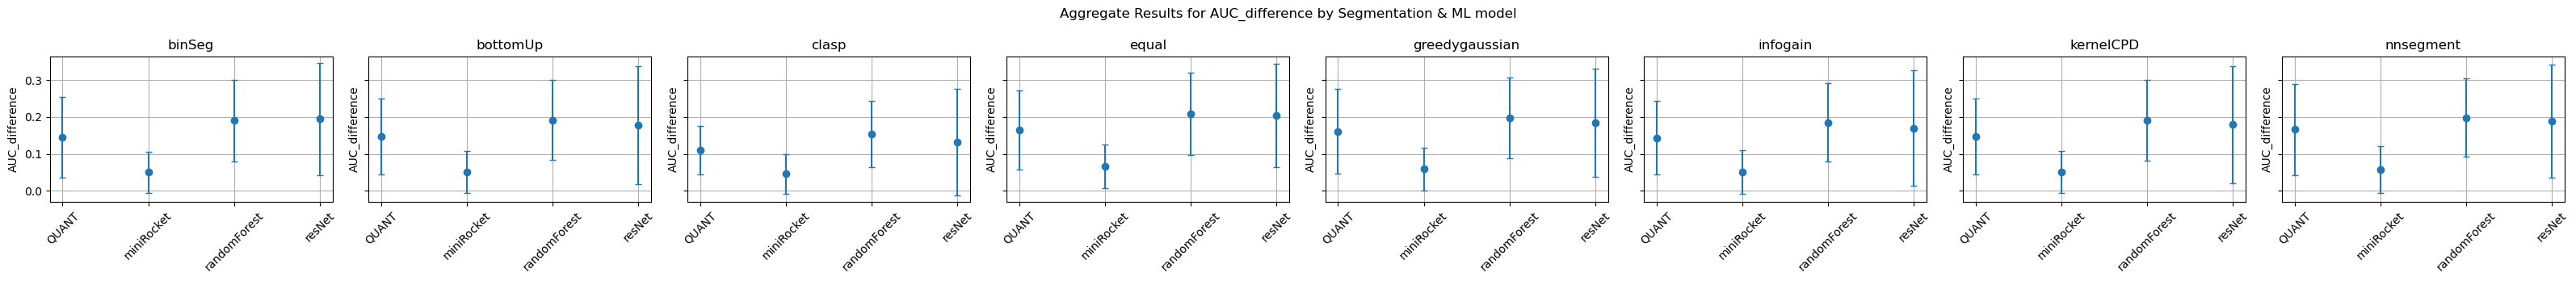

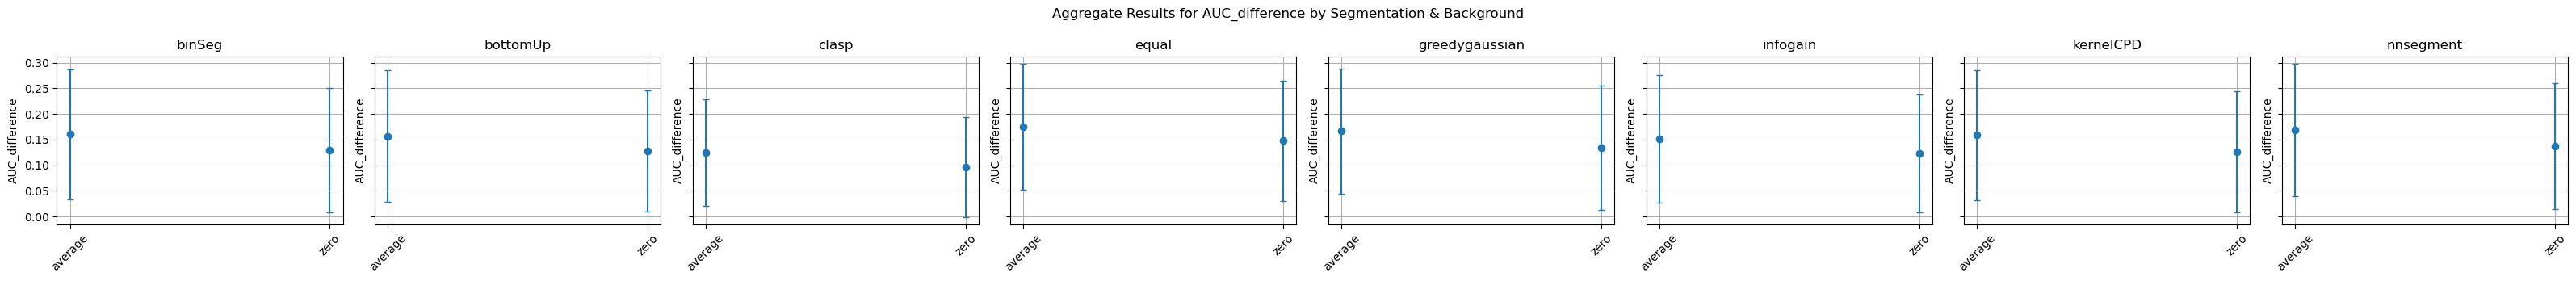

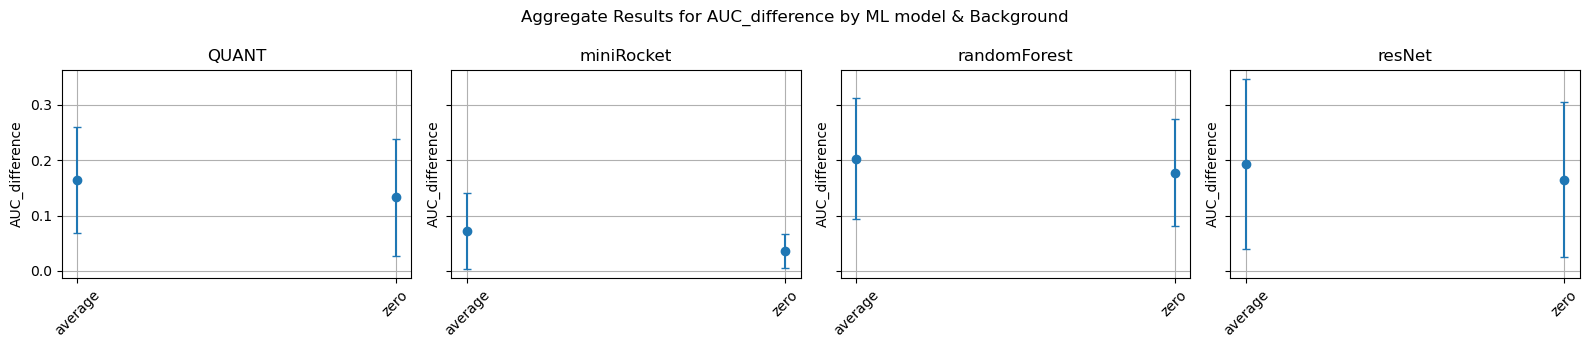

In [36]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = "AUC_difference"


mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
df2 = df.loc[mask] # , ['Perturb', "Result"]

for column_names in active_combinations:
    df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
    index_levels = df3.index.levels
    df3.columns = df3.columns.get_level_values(1)
    df3 = df3.reset_index()

    n_cols = len(index_levels[0])

    fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

    for j, column_name in enumerate(index_levels[0]):
        mask4 = df3[column_names[0]]==column_name
        df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
        df4 = df4.set_index(column_names[1])

        df4_mean = df4["mean"]
        df4_std = df4["std"]
        
        ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
        ax[j].grid()
        ax[j].tick_params("x", rotation=45)
        ax[j].set_title(column_name)
        ax[j].set_ylabel(metric_name)

        fig_name = f"Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
        fig.suptitle(fig_name)
        fig.tight_layout()
        fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [37]:
# sampling on resnet more consistent on auc deletion
# clasp worse on EOG pn both
# zero background worse on MP8

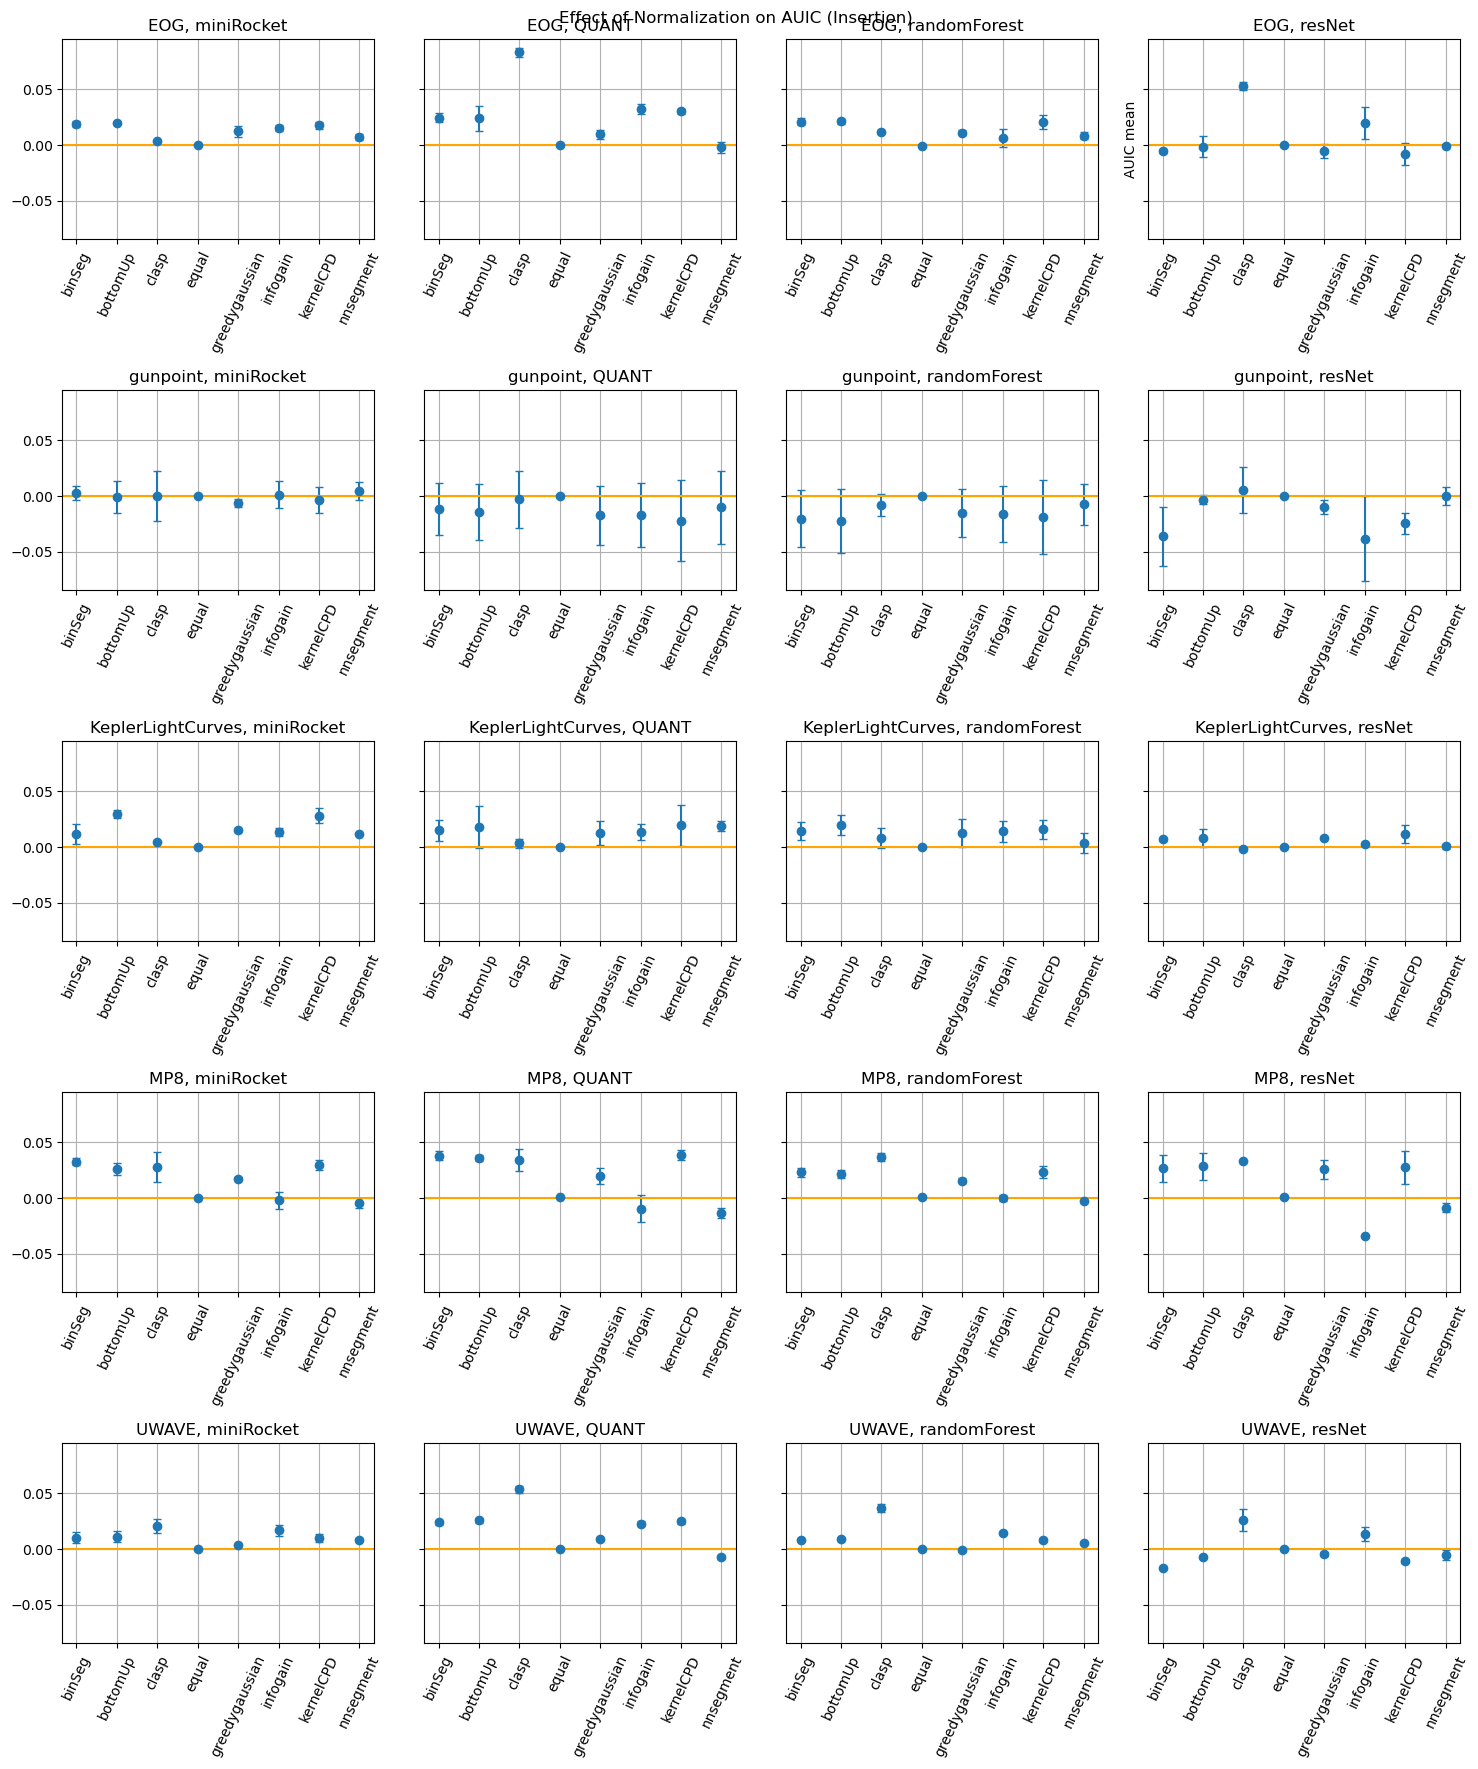

In [38]:
dataset_names = df["Dataset"].unique()
ml_model_names = df["ML model"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUC_difference") & (df["Perturb"]=="mean")# , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']
pivoted = pivoted.drop(columns=["default", "normalized"])

df3 = pivoted.groupby(["Dataset", "Segmentation", "ML model"]).agg({'DIFF': [("mean", "mean"), ("std", "std")]}).reset_index()

fig, ax = plt.subplots(len(dataset_names), len(ml_model_names), figsize = (15,18), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset]

    for j, ml_model_name in enumerate(ml_model_names):

        mask_ml = (df4["ML model"]==ml_model_name)
        df5 = df4.loc[mask_ml] # , ["Segmentation", 'DIFF']

        x = df5["Segmentation"].values
        means = df5[("DIFF", "mean")].values
        stds = df5[("DIFF", "std")].values

        yerr = stds

        ax[i, j].set_title(f"{dataset_name}, {ml_model_name}")
        ax[i, j].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
        ax[i, j].grid()
        ax[i, j].tick_params("x", rotation=65)
        ax[i, j].axhline(0.0, c="orange")

    ax[0, j].set_ylabel("AUIC mean")

fig.suptitle("Effect of Normalization on AUIC (Insertion)")
fig.tight_layout()

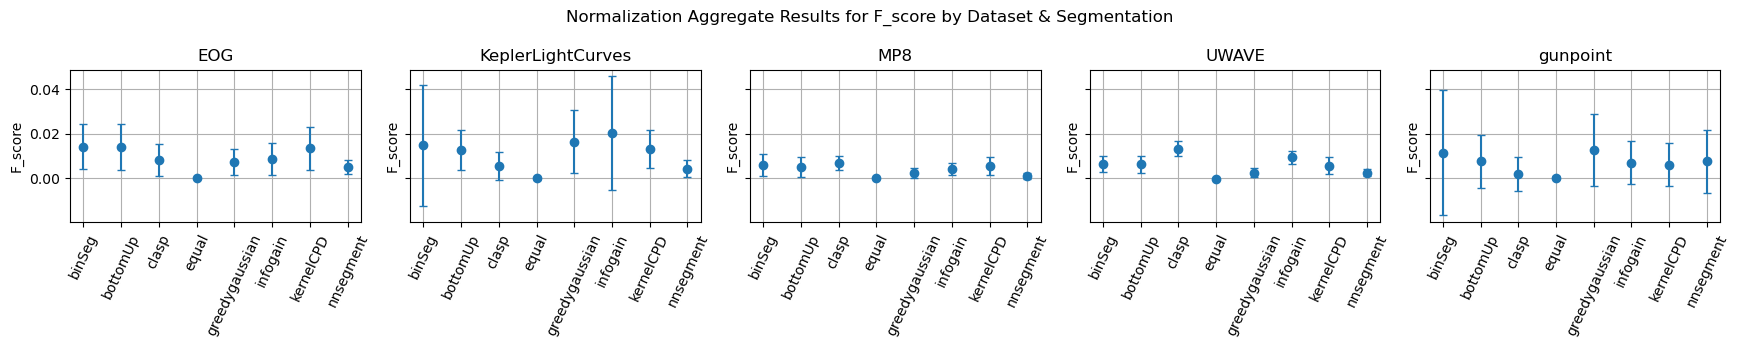

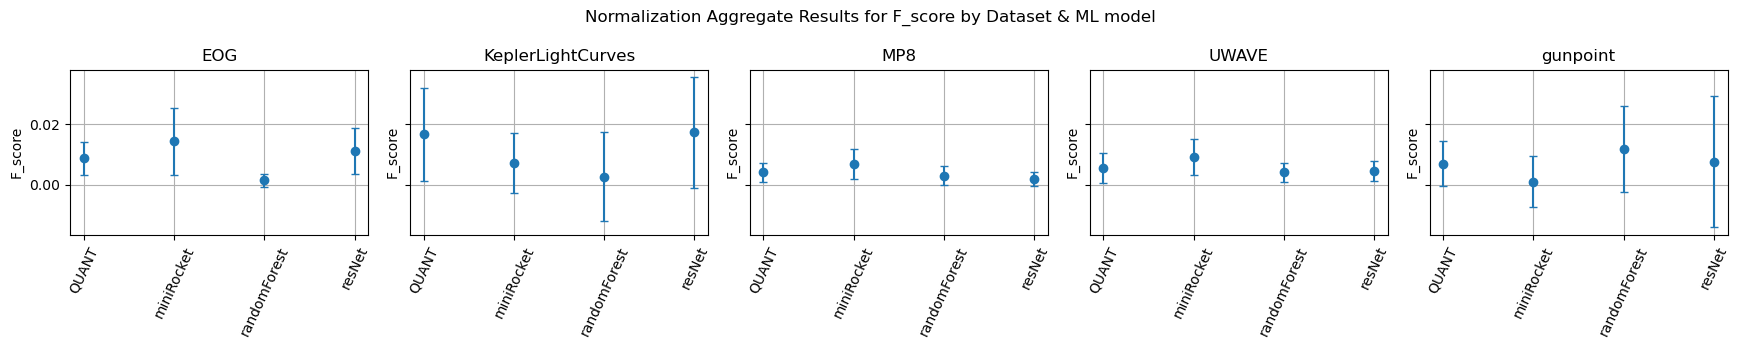

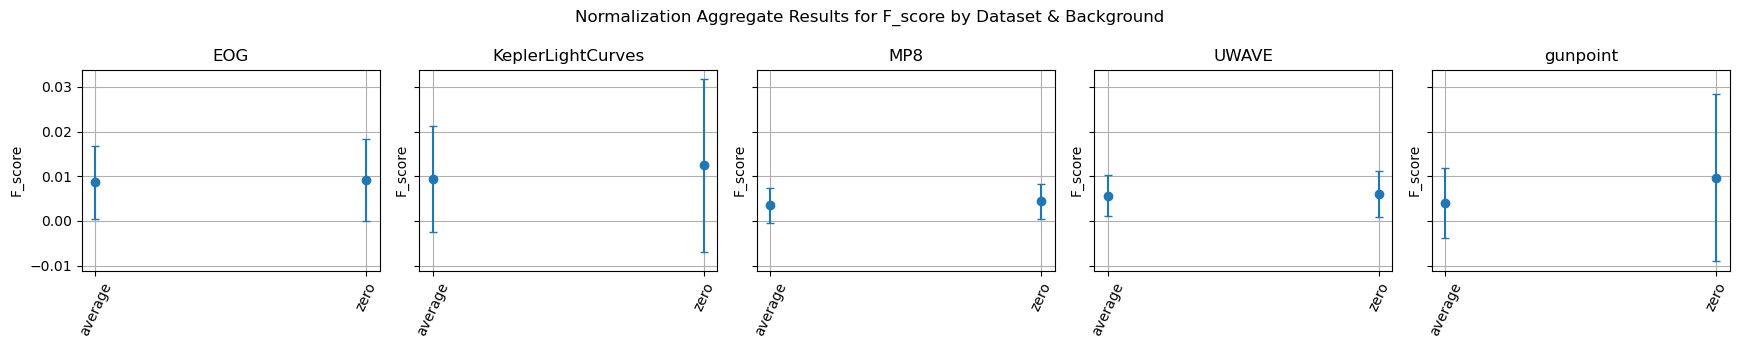

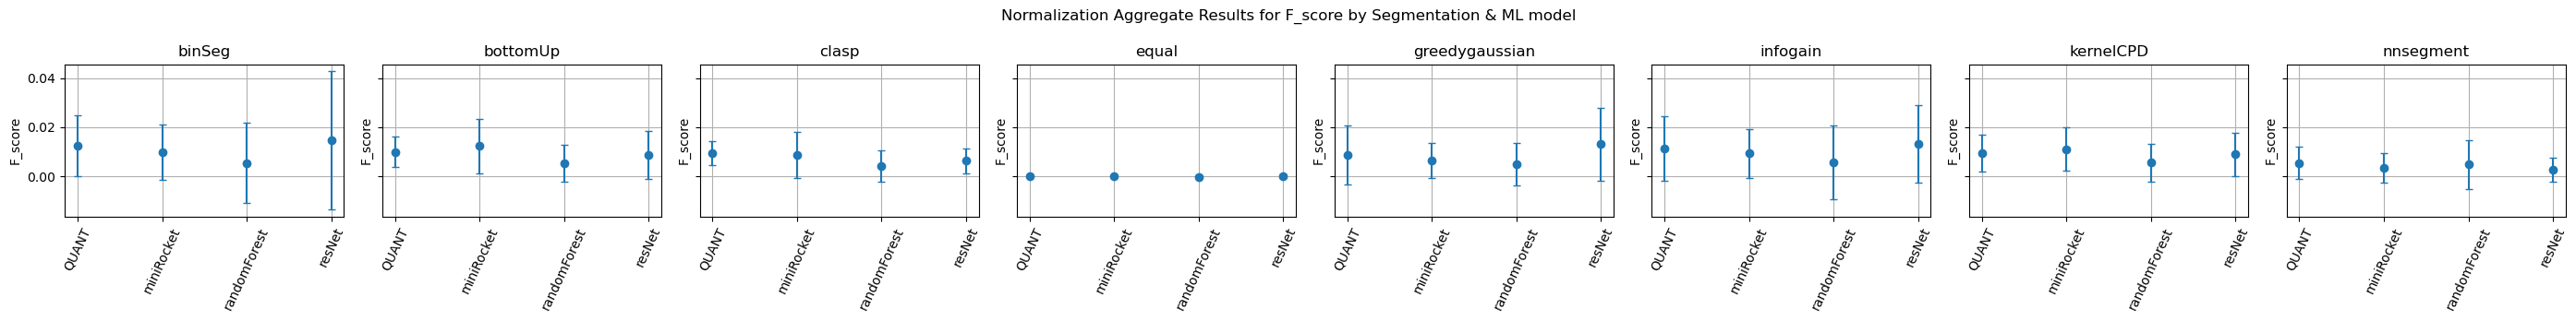

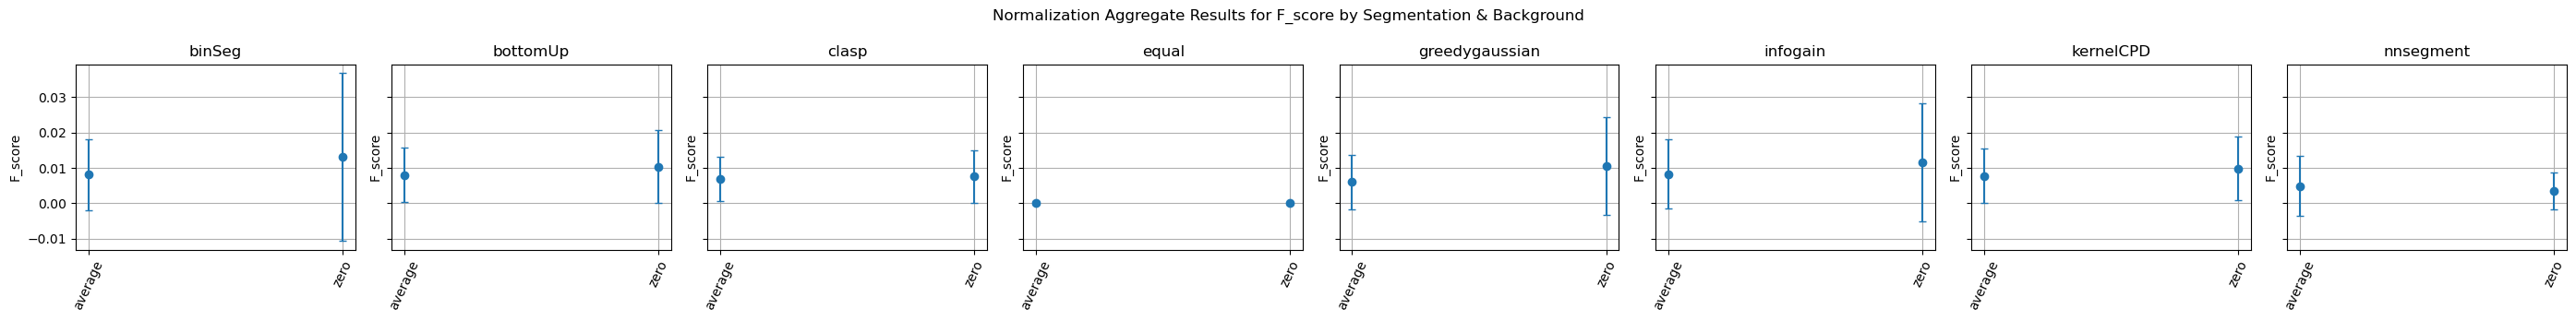

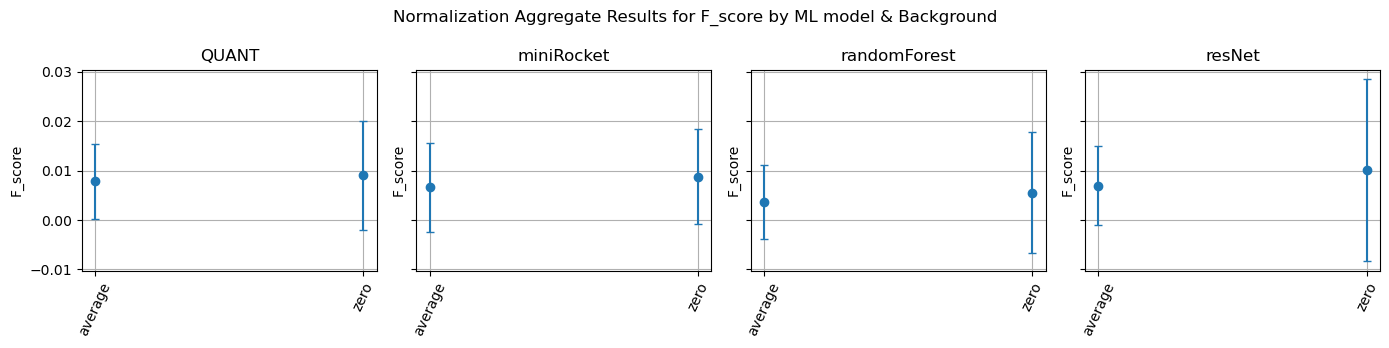

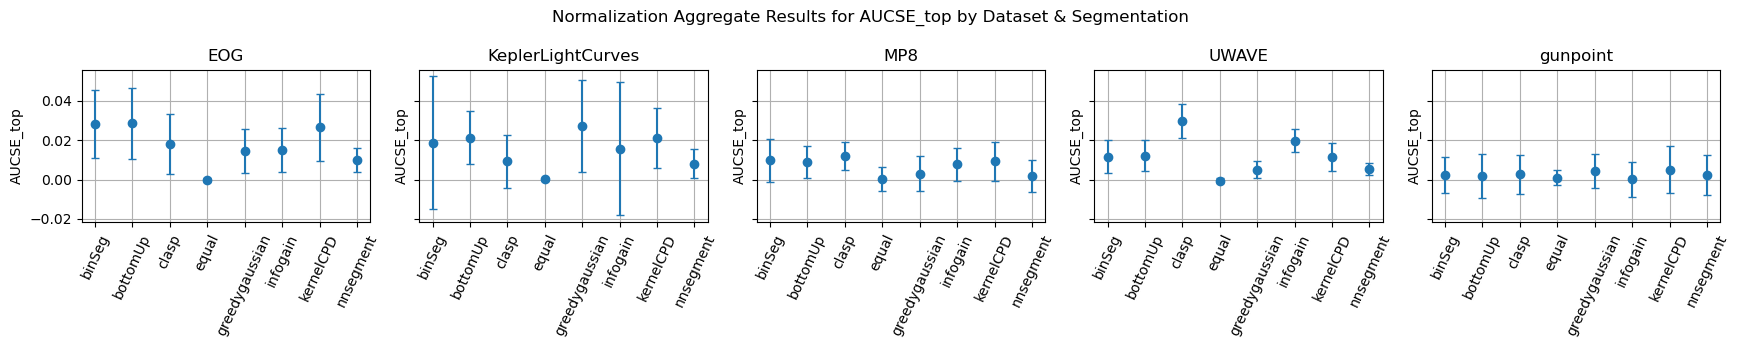

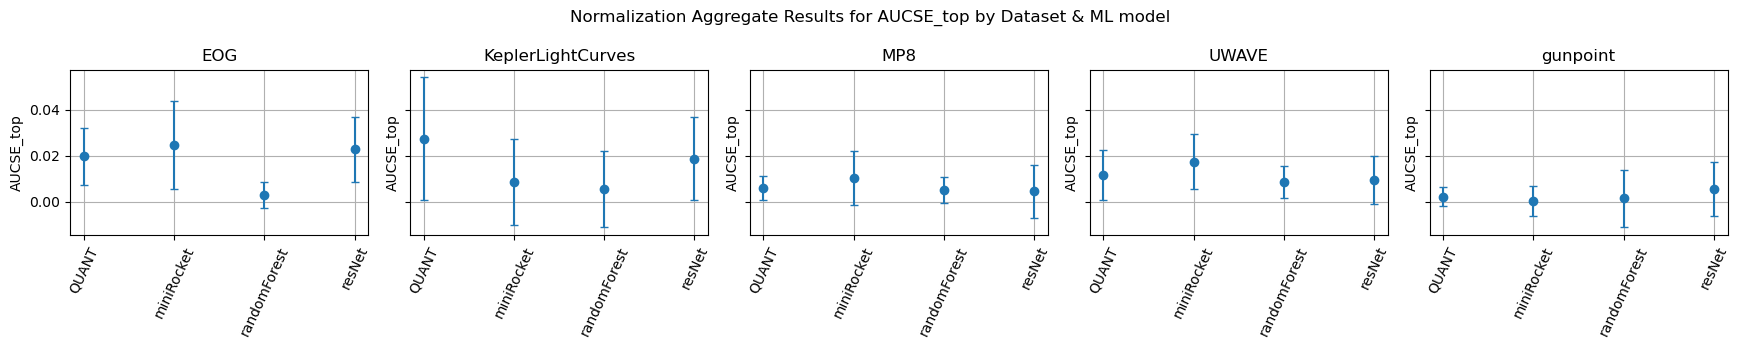

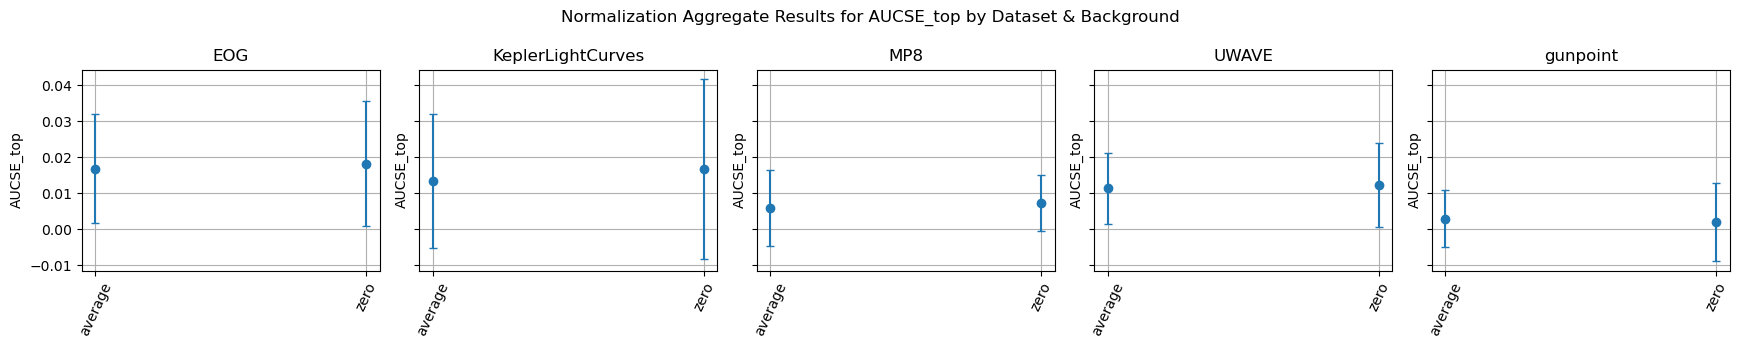

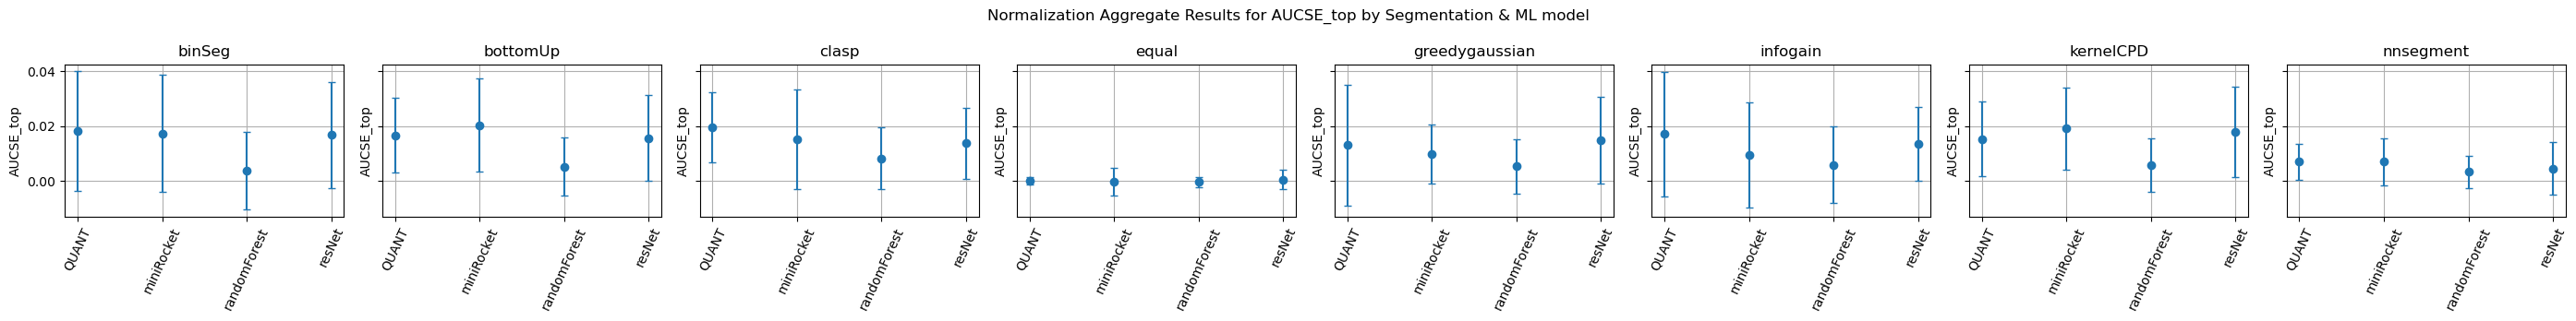

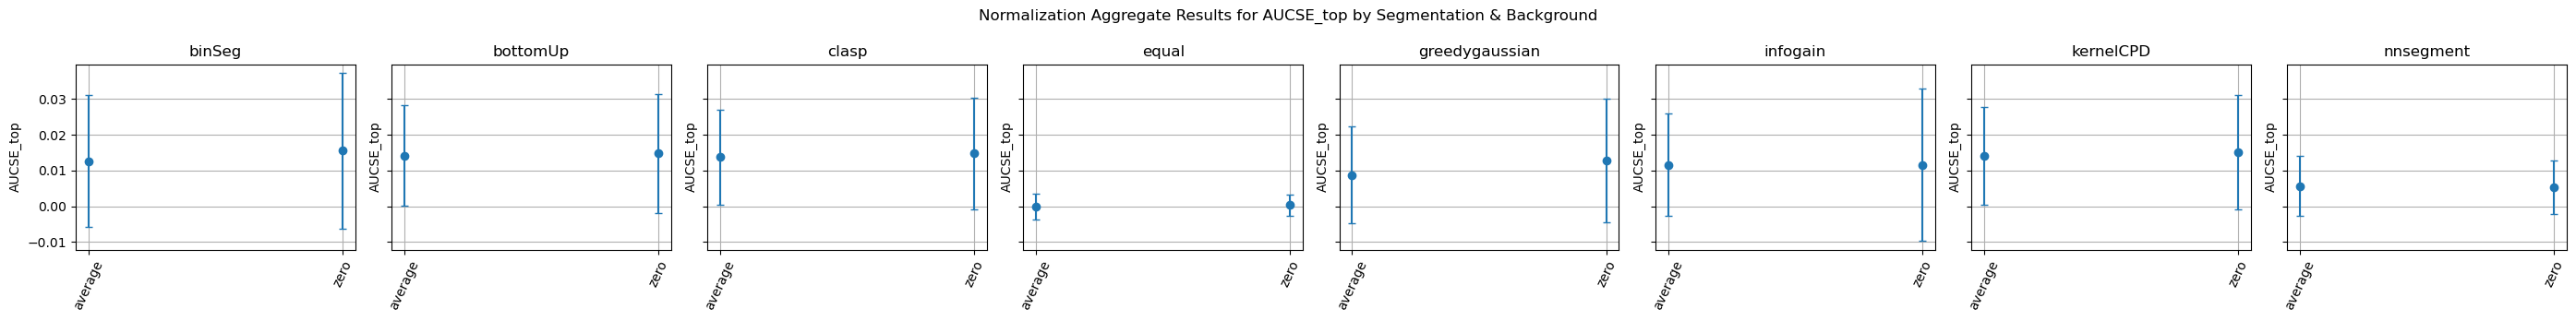

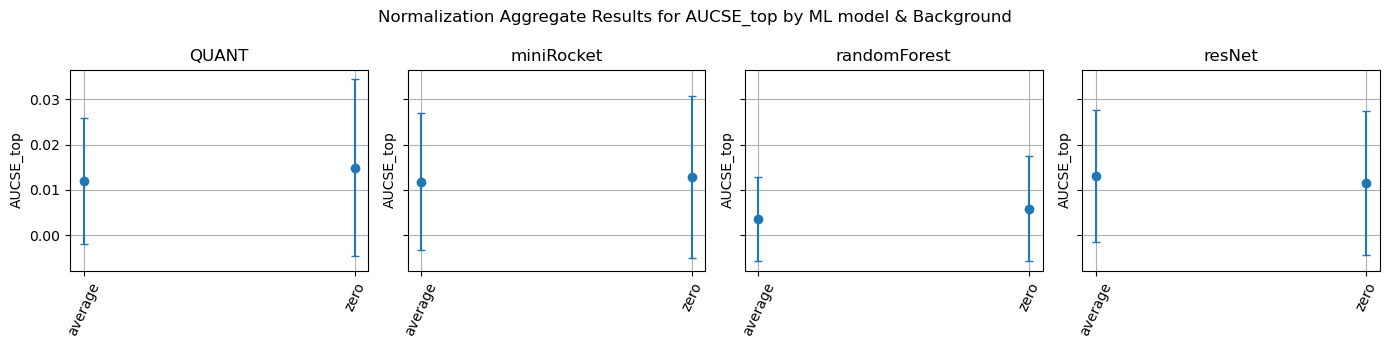

In [39]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_names = ["F_score", 'AUCSE_top'] # 


for metric_name in metric_names:

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask]
    pivoted = df2.pivot(index=df2.columns.difference(['Normalization', "Result"]).tolist(), columns='Normalization', values='Result').reset_index()
    pivoted['Result'] = pivoted['normalized'] - pivoted['default']
    pivoted = pivoted.drop(columns=["default", "normalized"])

    for column_names in active_combinations:
        #column_names = column_names[::-1]
        df3 = pivoted.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()
        # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
        # print(index_levels)

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Normalization Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/normalization/" + fig_name + ".png") # , dpi=100

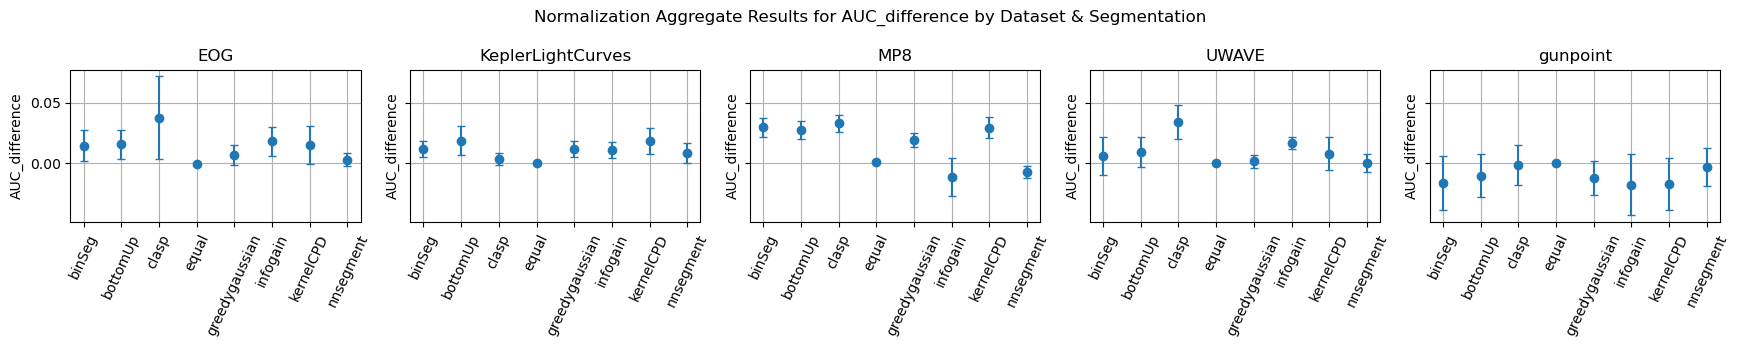

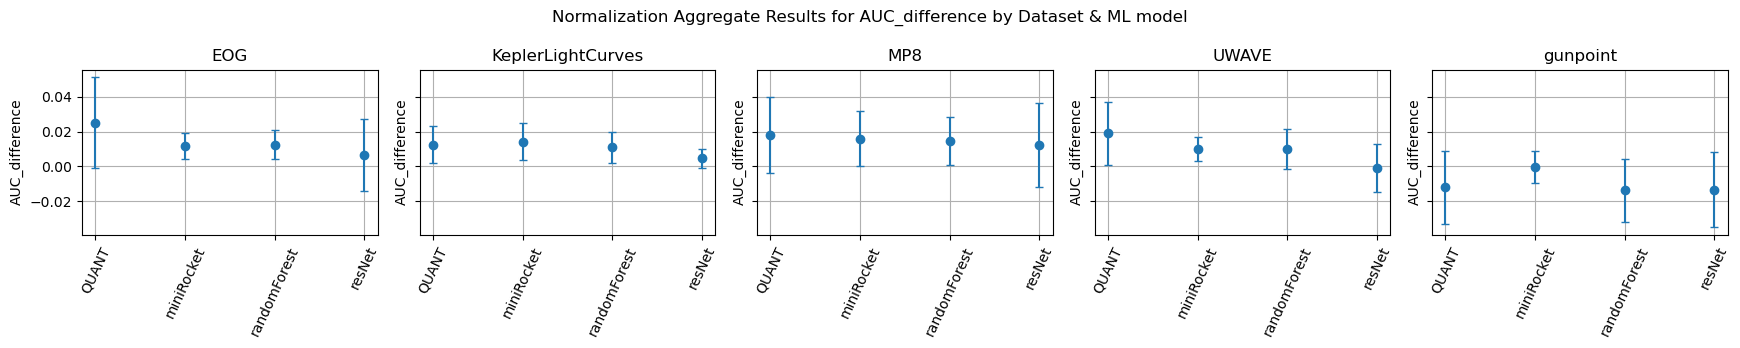

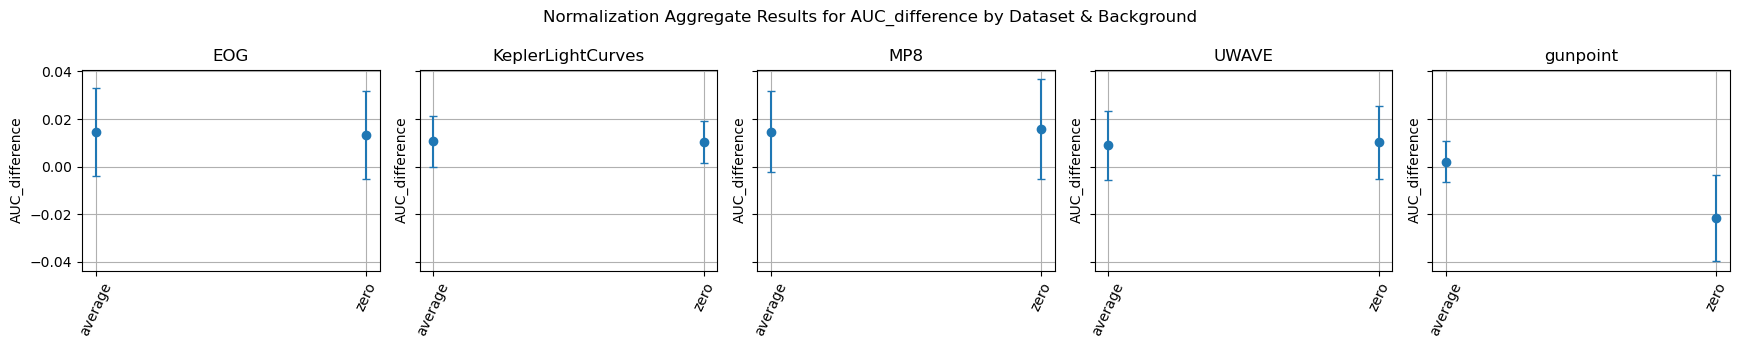

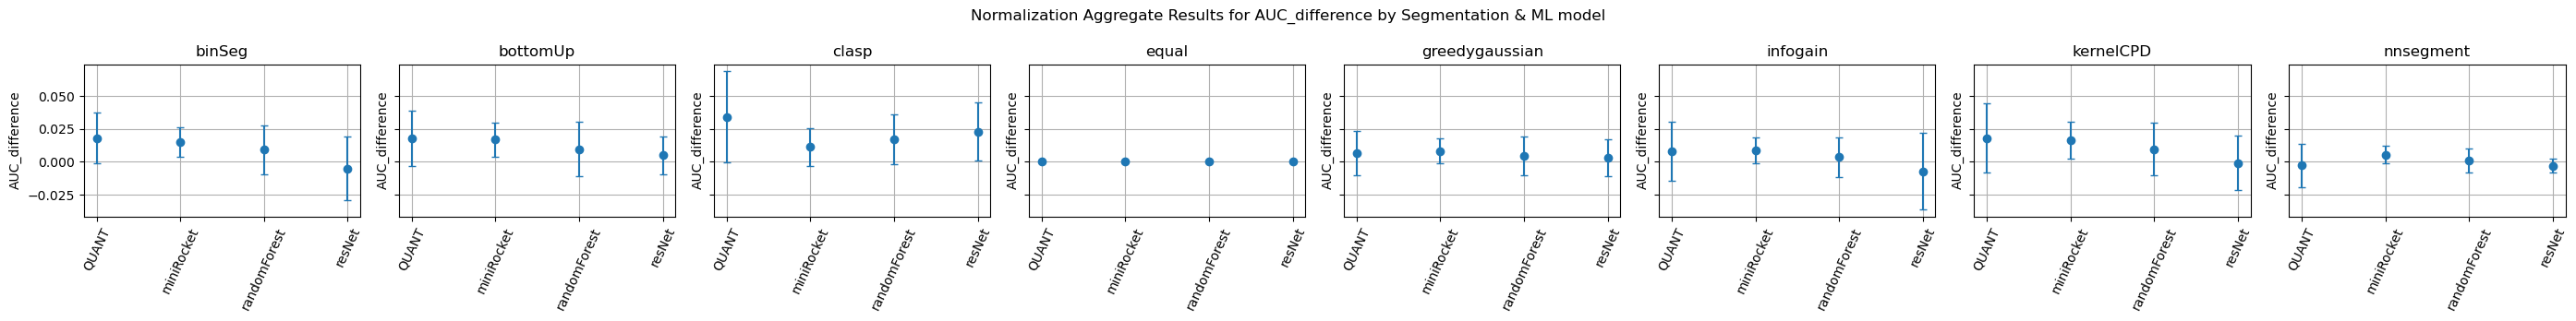

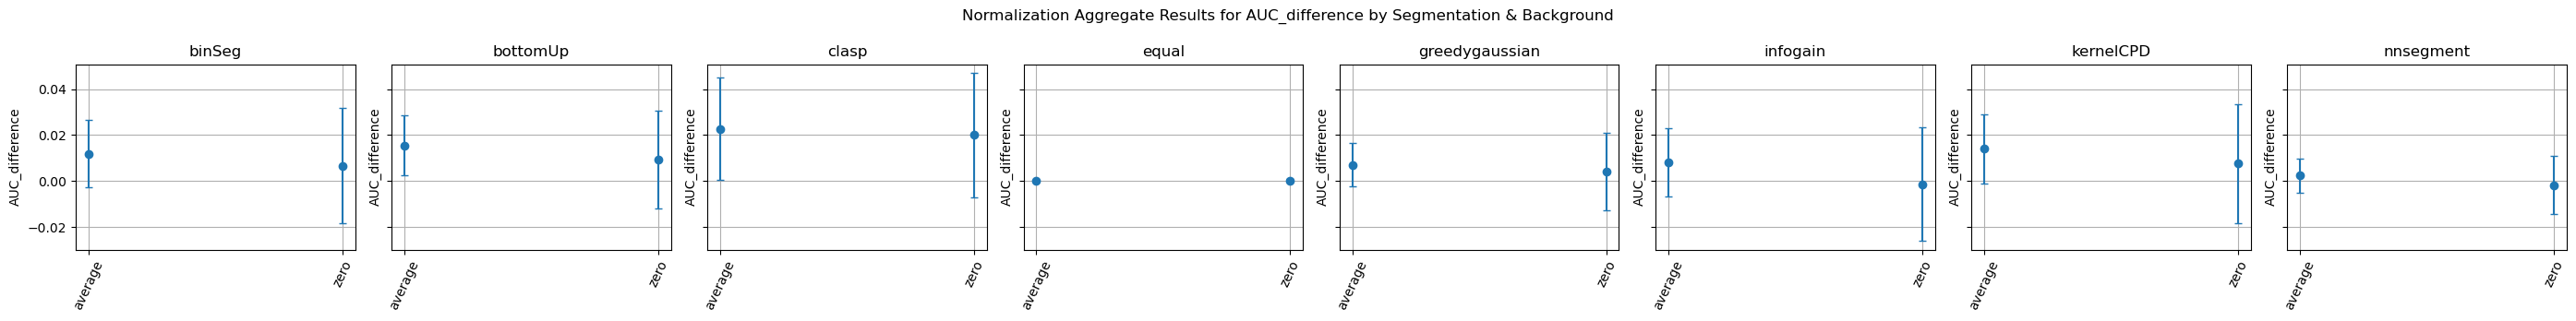

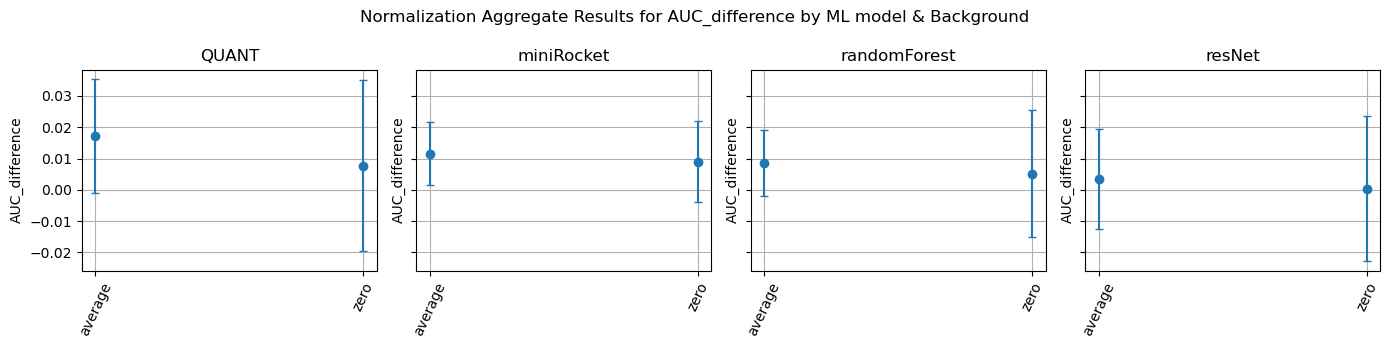

In [40]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = 'AUC_difference'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask]

# values_to_delete = ['insertion_std', 'deletion_std']
# filtered_df = df2[~df2['Perturb'].isin(values_to_delete)]
# pivoted = filtered_df.pivot_table(index=filtered_df.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
# pivoted['Result'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
# pivoted['Perturb'] = 'mean'
# df2 = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)

pivoted = df2.pivot(index=df2.columns.difference(['Normalization', "Result"]).tolist(), columns='Normalization', values='Result').reset_index()
pivoted['Result'] = pivoted['normalized'] - pivoted['default']
pivoted = pivoted.drop(columns=["default", "normalized"])

for column_names in active_combinations:
    #column_names = column_names[::-1]
    df3 = pivoted.groupby([*column_names]).agg({'Result': ["mean", "std"]})
    index_levels = df3.index.levels
    df3.columns = df3.columns.get_level_values(1)
    df3 = df3.reset_index()
    # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
    # print(index_levels)

    n_cols = len(index_levels[0])

    fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

    for j, column_name in enumerate(index_levels[0]):
        mask4 = df3[column_names[0]]==column_name
        df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
        df4 = df4.set_index(column_names[1])

        df4_mean = df4["mean"]
        df4_std = df4["std"]
        
        ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
        ax[j].grid()
        ax[j].tick_params("x", rotation=65)
        ax[j].set_title(column_name)
        ax[j].set_ylabel(metric_name)

        fig_name = f"Normalization Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
        fig.suptitle(fig_name)
        fig.tight_layout()
        fig.savefig(images_path + "/normalization/" + fig_name + ".png") # , dpi=100

In [ ]:
0/0

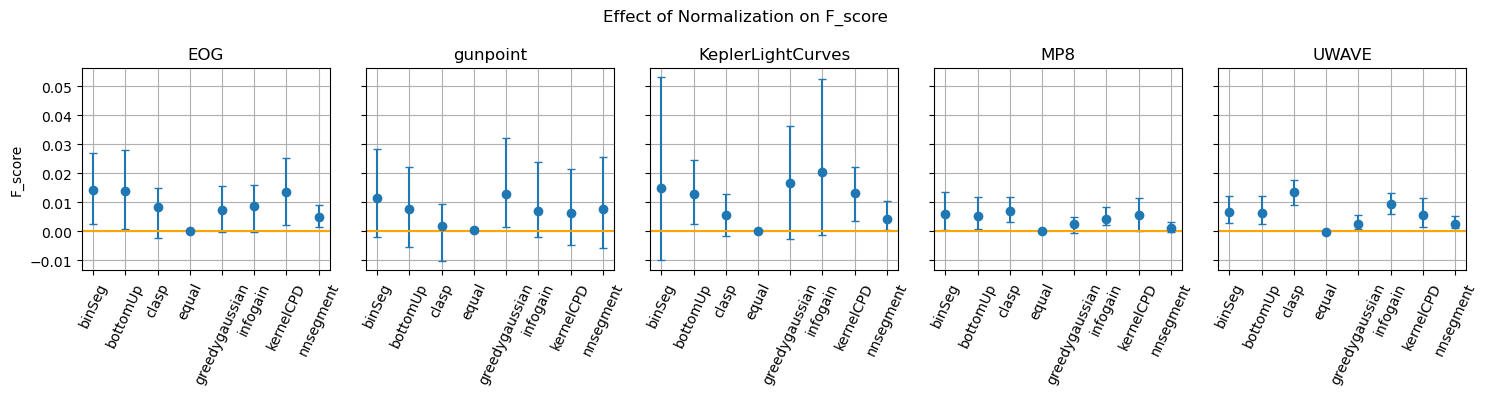

In [41]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="F_score") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': [("mean", "mean"), ("q10", lambda x: x.quantile(0.10)), ("q90", lambda x: x.quantile(0.90))]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    q10 = df4[("DIFF", "q10")].values
    q90 = df4[("DIFF", "q90")].values

    yerr = [means - q10, q90 - means]

    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)
    ax[i].axhline(0.0, c="orange")

ax[0].set_ylabel("F_score")

fig.suptitle("Effect of Normalization on F_score")
fig.tight_layout()

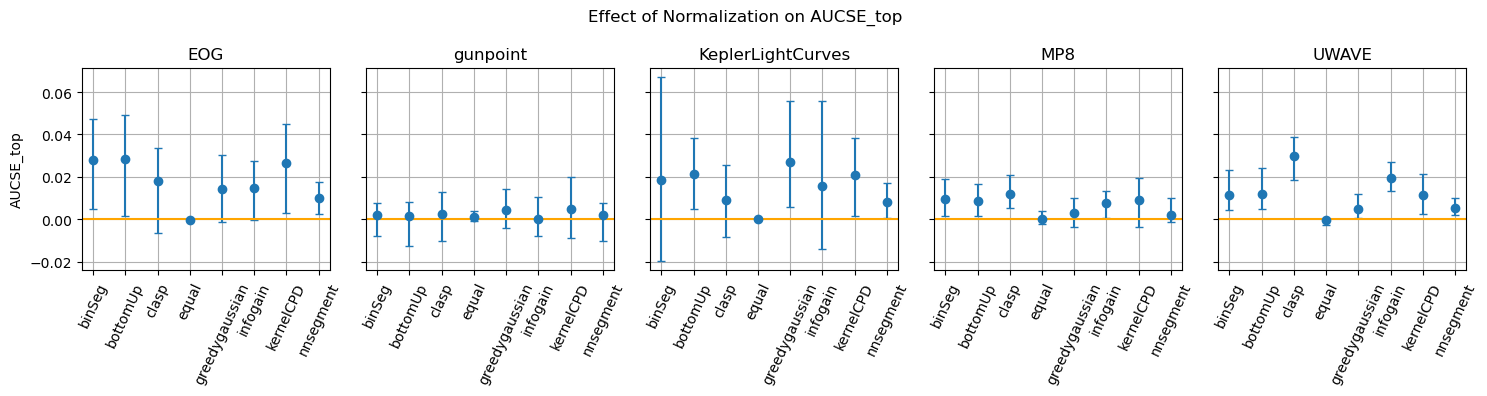

In [42]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=='AUCSE_top') # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': [("mean", "mean"), ("q10", lambda x: x.quantile(0.10)), ("q90", lambda x: x.quantile(0.90))]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    q10 = df4[("DIFF", "q10")].values
    q90 = df4[("DIFF", "q90")].values

    yerr = (means - q10, np.where((q90>means), q90 - means, 0.0))

    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)
    ax[i].axhline(0.0, c="orange")

ax[0].set_ylabel("AUCSE_top")

fig.suptitle("Effect of Normalization on AUCSE_top")
fig.tight_layout()

In [ ]:
0/0

In [42]:
from itertools import combinations

In [45]:
pairs_of_interest = [("KeplerLightCurves", "resNet"), ("gunpoint", "miniRocket"), ("MP8", "miniRocket")]

In [46]:
columns_wo_result

['Dataset',
 'Segmentation',
 'ML model',
 'Background',
 'Normalization',
 'Perturb',
 'Metric']

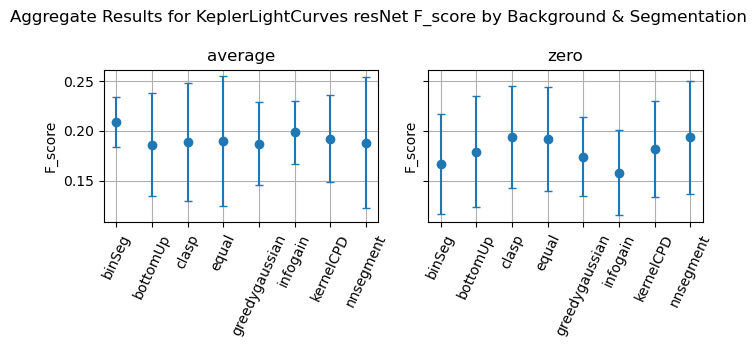

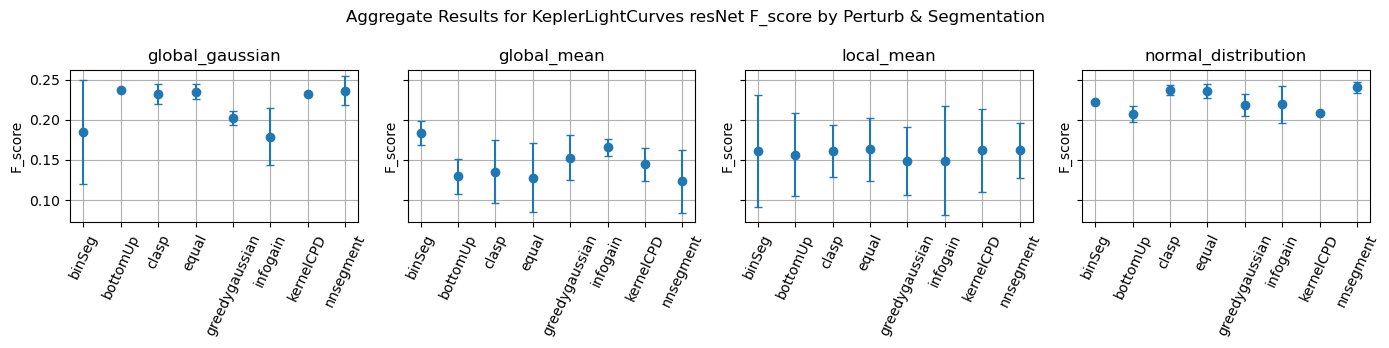

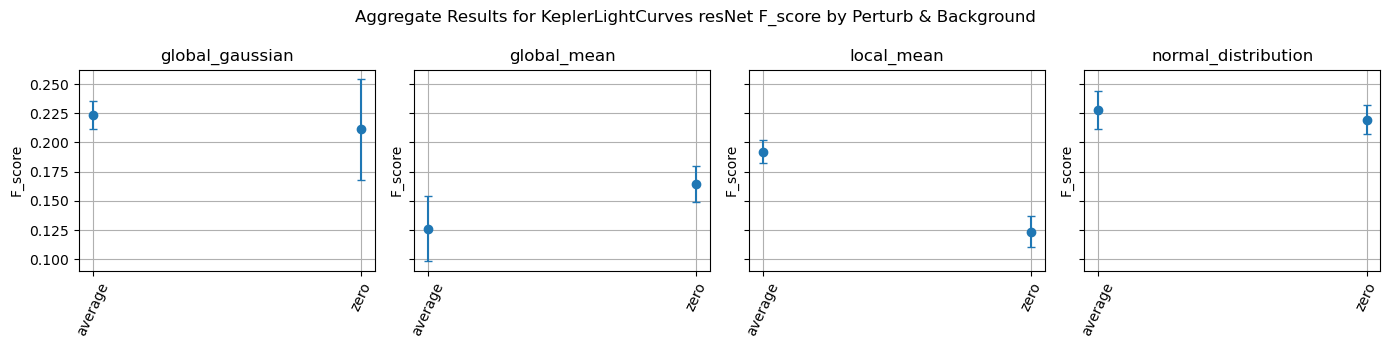

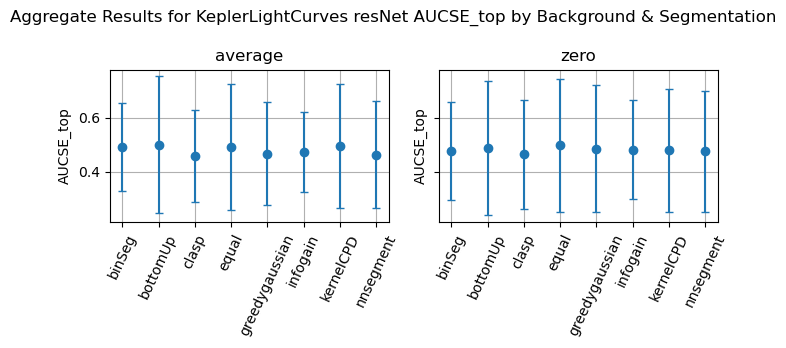

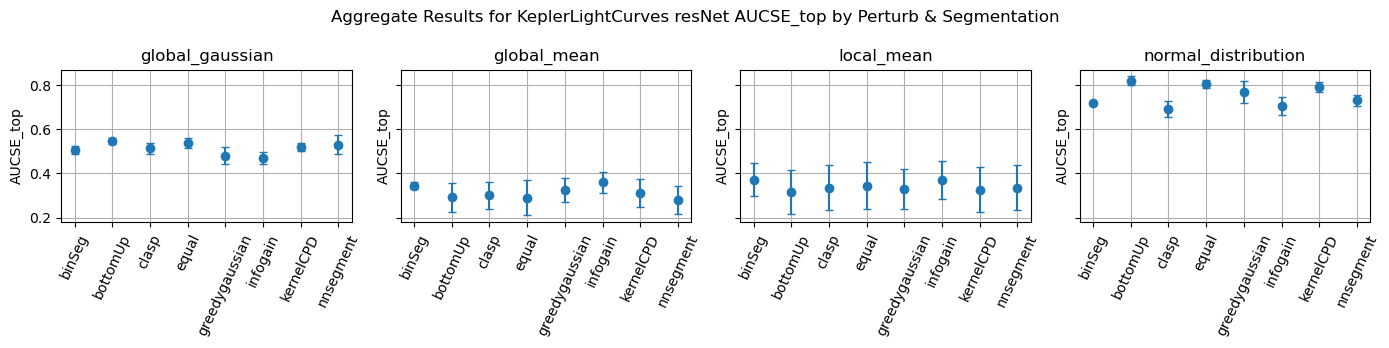

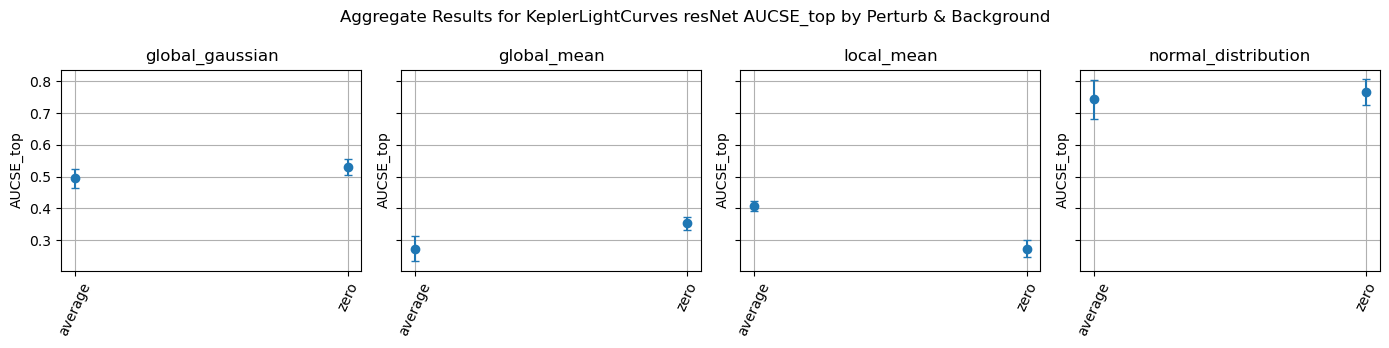

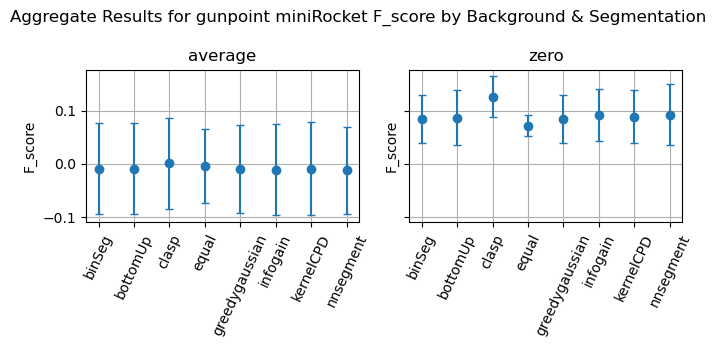

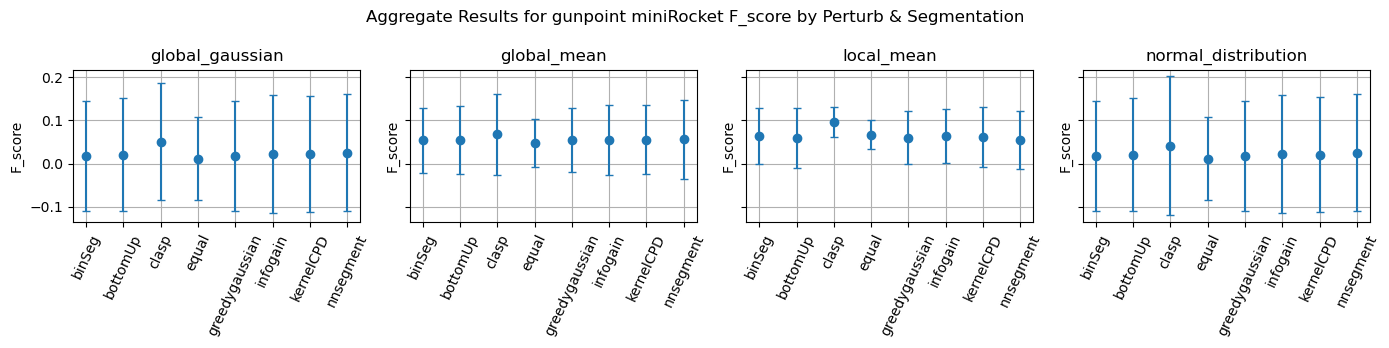

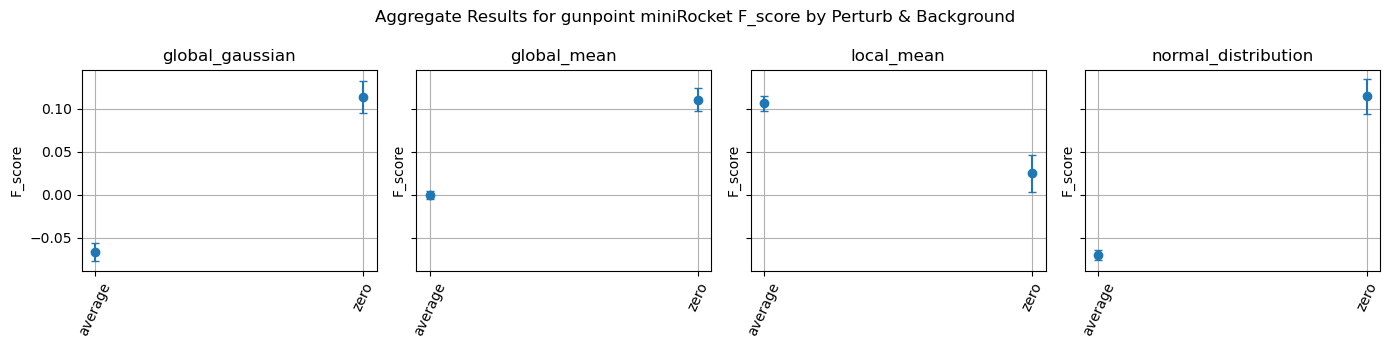

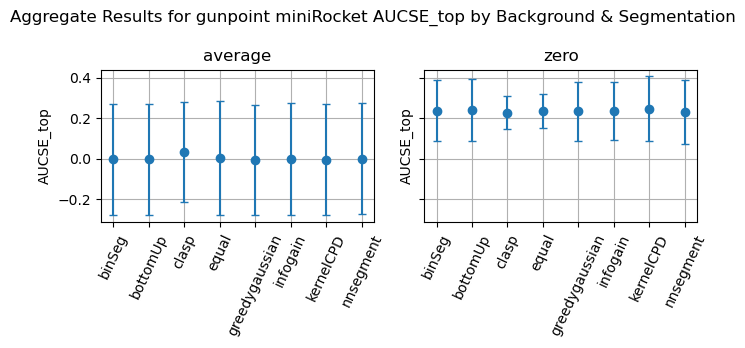

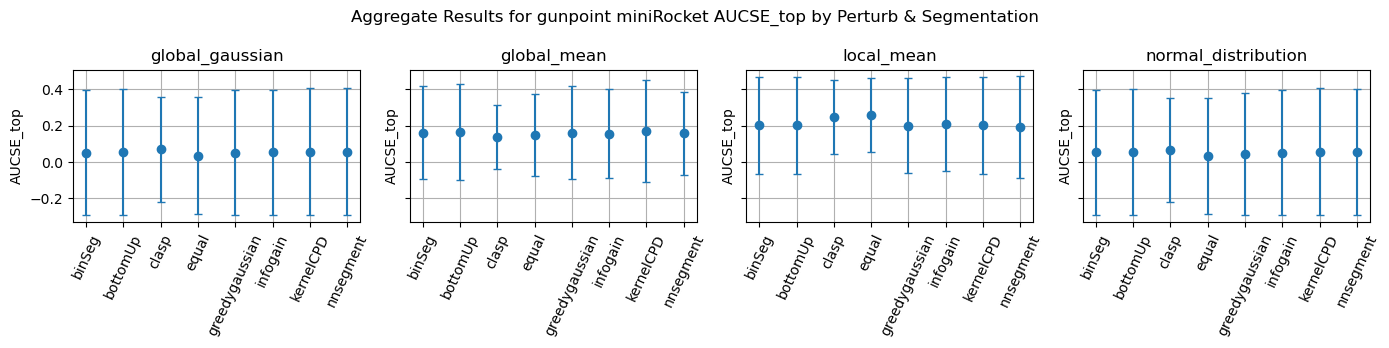

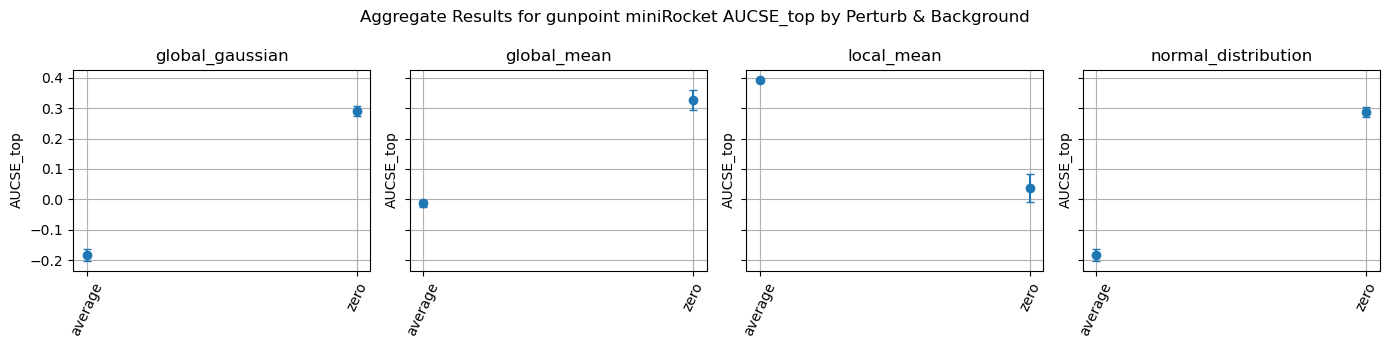

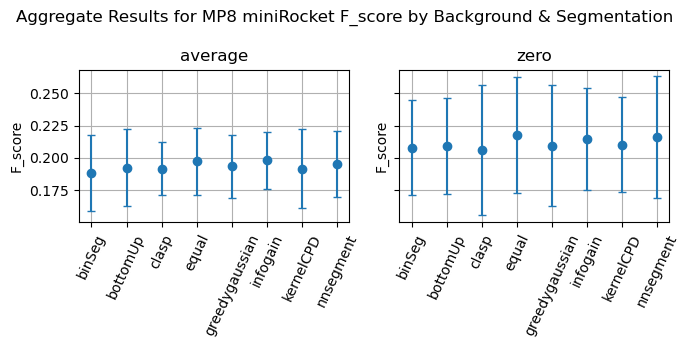

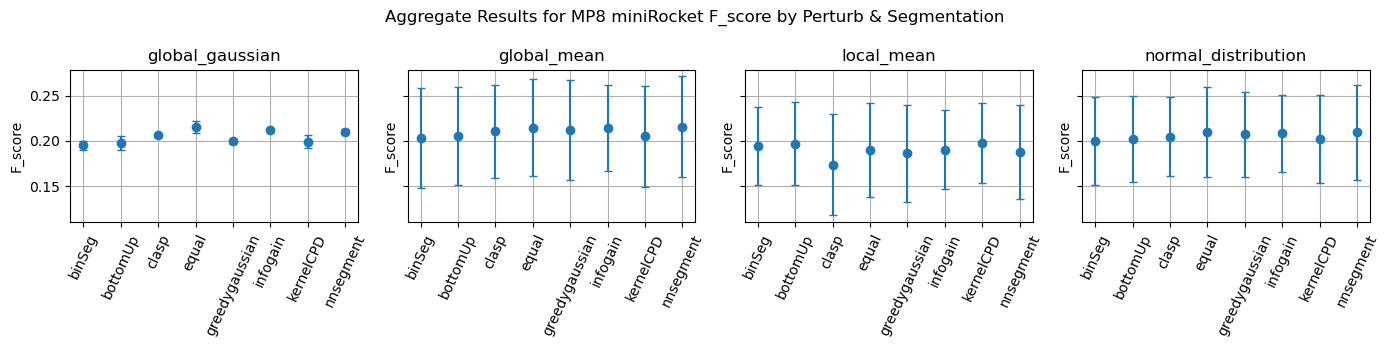

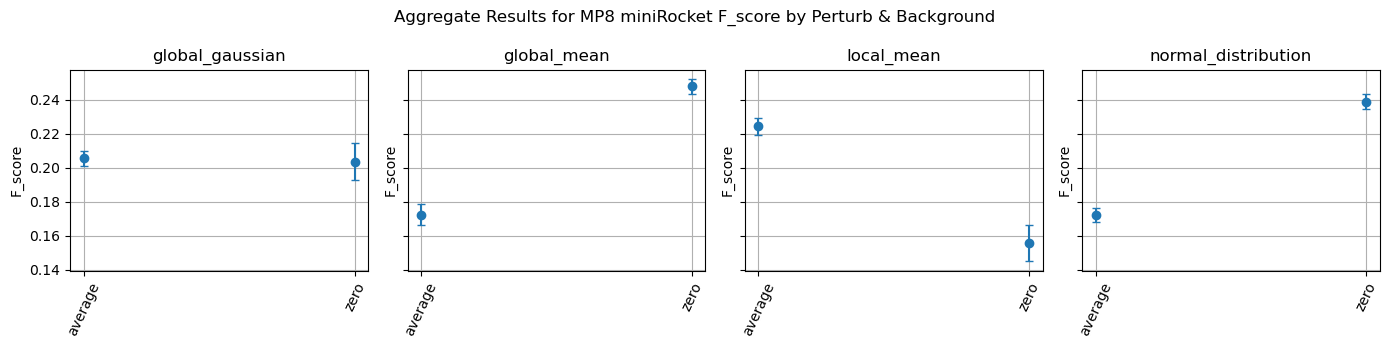

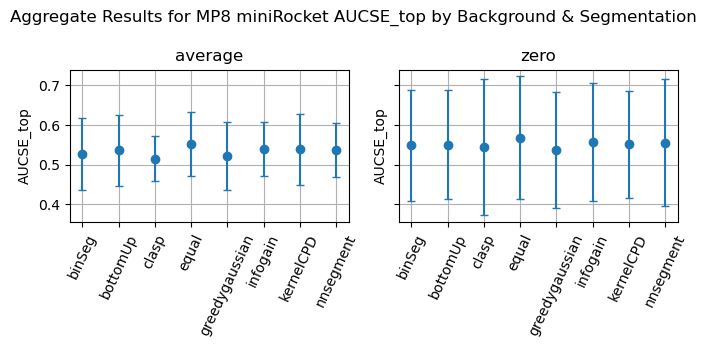

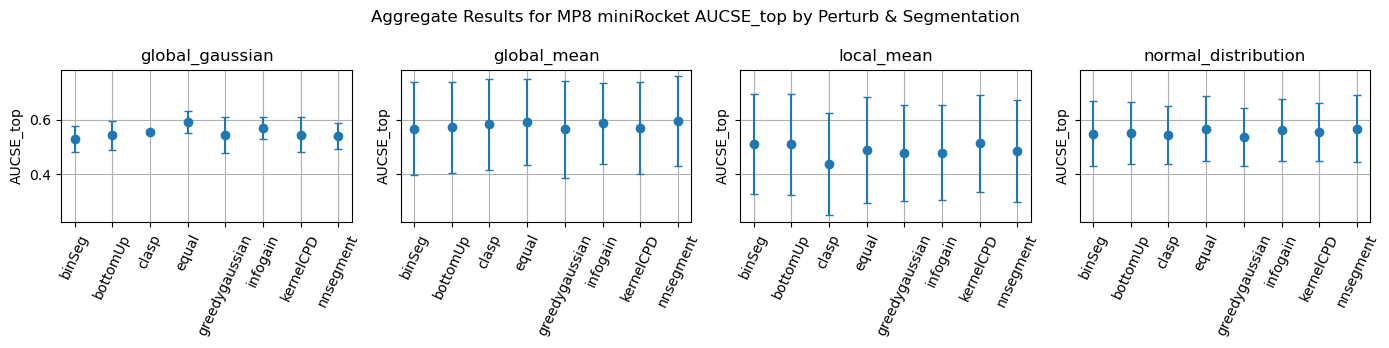

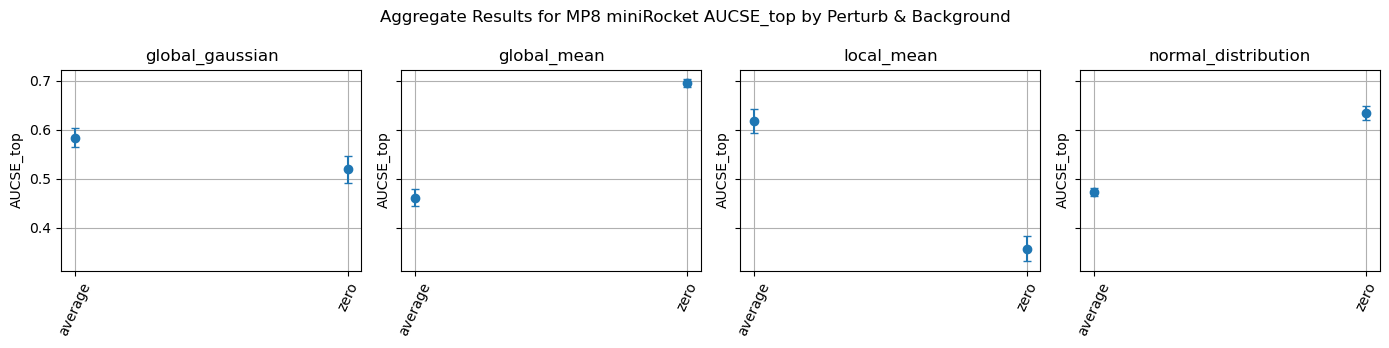

In [47]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_names = ["F_score", 'AUCSE_top']

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    for metric_name in metric_names:

        mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
        df2 = df.loc[mask] # , ['Perturb', "Result"]
        # col_unique_lengths = []
        # for col in df2[active_columns]:
        #     col_unique_lengths.append(len(df2[col].unique()))
        # n_rows = len(active_combinations)
        # max_cols = np.max(col_unique_lengths)

        for column_names in active_combinations:
            column_names = column_names[::-1]
            df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
            index_levels = df3.index.levels
            df3.columns = df3.columns.get_level_values(1)
            df3 = df3.reset_index()
            # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
            # print(index_levels)

            n_cols = len(index_levels[0])

            fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

            for j, column_name in enumerate(index_levels[0]):
                mask4 = df3[column_names[0]]==column_name
                df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
                df4 = df4.set_index(column_names[1])

                df4_mean = df4["mean"]
                df4_std = df4["std"]
                
                ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
                ax[j].grid()
                ax[j].tick_params("x", rotation=65)
                ax[j].set_title(column_name)
                ax[j].set_ylabel(metric_name)

                fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {metric_name} by {column_names[0]} & {column_names[1]}"
                fig.suptitle(fig_name)
                fig.tight_layout()
                fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [55]:
pairs_of_interest = [("KeplerLightCurves", "resNet"), ("gunpoint", "miniRocket"), ("MP8", "miniRocket")]

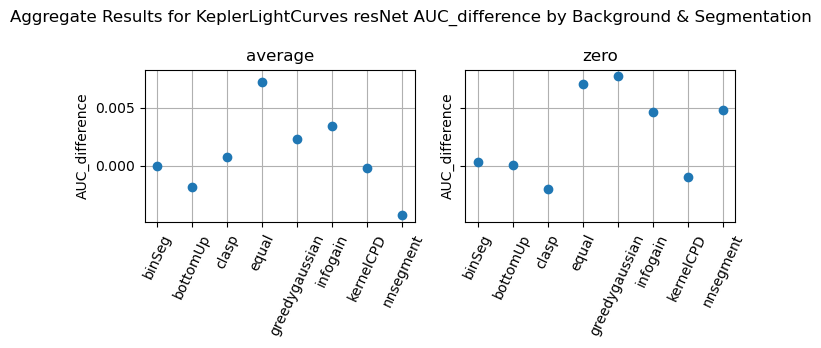

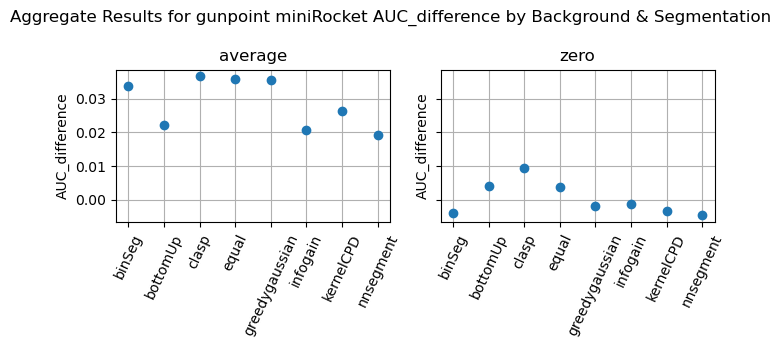

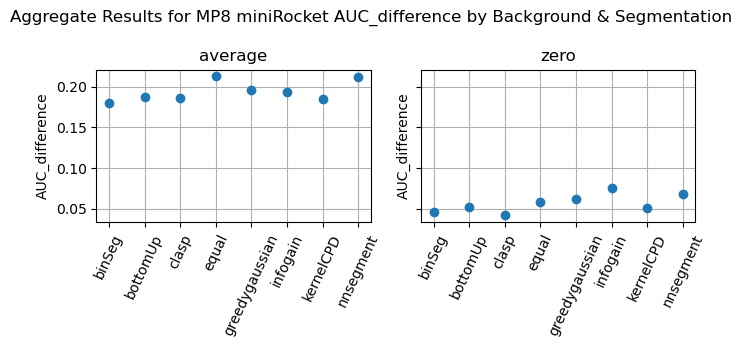

In [56]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = "AUC_difference"
perturb_names = ["mean"]

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    mask = (df["Metric"]==metric_name) & (df["Perturb"]==perturb_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
        # col_unique_lengths = []
        # for col in df2[active_columns]:
        #     col_unique_lengths.append(len(df2[col].unique()))
        # n_rows = len(active_combinations)
        # max_cols = np.max(col_unique_lengths)

    for column_names in active_combinations:
        column_names = column_names[::-1]
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()
        # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
        # print(index_levels)

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [ ]:
0/0

ZeroDivisionError: division by zero